# Title of Your Group Project

This Python notebook serves as a template for your group project for the course "Modeling in Cognitive Science".

This is the practical part of the group project where you get to implement the computational modeling workflow. In this part, you are expected to:


*   Implement at least two computational models relevant for your hypothesis. *(3 points)*
*   Simulate behavior from the two models. *(3 points)*
*   Implement a procedure for fitting the models to data. *(4 points)*
*   Implement a procedure for parameter recovery. *(5 points)*
*   (Implement a procedure for model recovery.) *(optional; 2 bonus points)*
*   Implement a model comparison. *(5 points)*.

You can gain a total of 20 points for the practical part of the group project.

**Note:** *Some of the exercises below (e.g. Model Simulation) rely on code from previous exercises (e.g., Model Implementation). In such cases, you are encouraged to rely on functions implemented for previous exercises. That is, you don't have to produce redundant code.*



## Model Implementation *(3 points)*

For this exercise you should:

*   Implement and simulate data from two* models that are suitable to test your hypothesis. *(3 points)*

<font size=2>*You may implement more than two models if you wish. However, two models are sufficient for this group project.</font>

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


In [96]:
from simulate import simulate
from utils import calculate_stay_probability, plot_stay_probabilities, print_simple_statistics,\
    save_simulated_data

In [97]:
# Run simulation with default parameter and save to csv
seed = 0
task_df_r , agent_r= simulate(agent_type='random', seed=seed)
task_df_mf , agent_mf= simulate(agent_type='model_free', seed=seed)
task_df_mb , agent_mb= simulate(agent_type='model_based', seed=seed)
task_df_hybrid , agent_hybrid= simulate(agent_type='hybrid', seed=seed)
task_df_hybrid_mf , agent_hybrid_mf= simulate(agent_type='hybrid', seed=seed, params={'w':0.0})
task_df_hybrid_mb , agent_hybrid_mb= simulate(agent_type='hybrid', seed=seed, params={'w':1.0})
# save_simulated_data(task_df_r, agent_type='random')
# save_simulated_data(task_df_mf, agent_type='model_free')
# save_simulated_data(task_df_mb, agent_type='model_based')
# save_simulated_data(task_df_hybrid, agent_type='hybrid')
# save_simulated_data(task_df_hybrid_mf, agent_type='hybrid_mf')
# save_simulated_data(task_df_hybrid_mb, agent_type='hybrid_mb')

### random
common transitions percentage: 69.0 %
rewarded trails percentage: 53.0 %
### model_free
common transitions percentage: 72.5 %
rewarded trails percentage: 42.0 %
### model_based
common transitions percentage: 70.0 %
rewarded trails percentage: 48.0 %
### hybrid
common transitions percentage: 70.0 %
rewarded trails percentage: 50.5 %
### hybrid_mf
common transitions percentage: 70.0 %
rewarded trails percentage: 50.5 %
### hybrid_mb
common transitions percentage: 70.0 %
rewarded trails percentage: 50.5 %


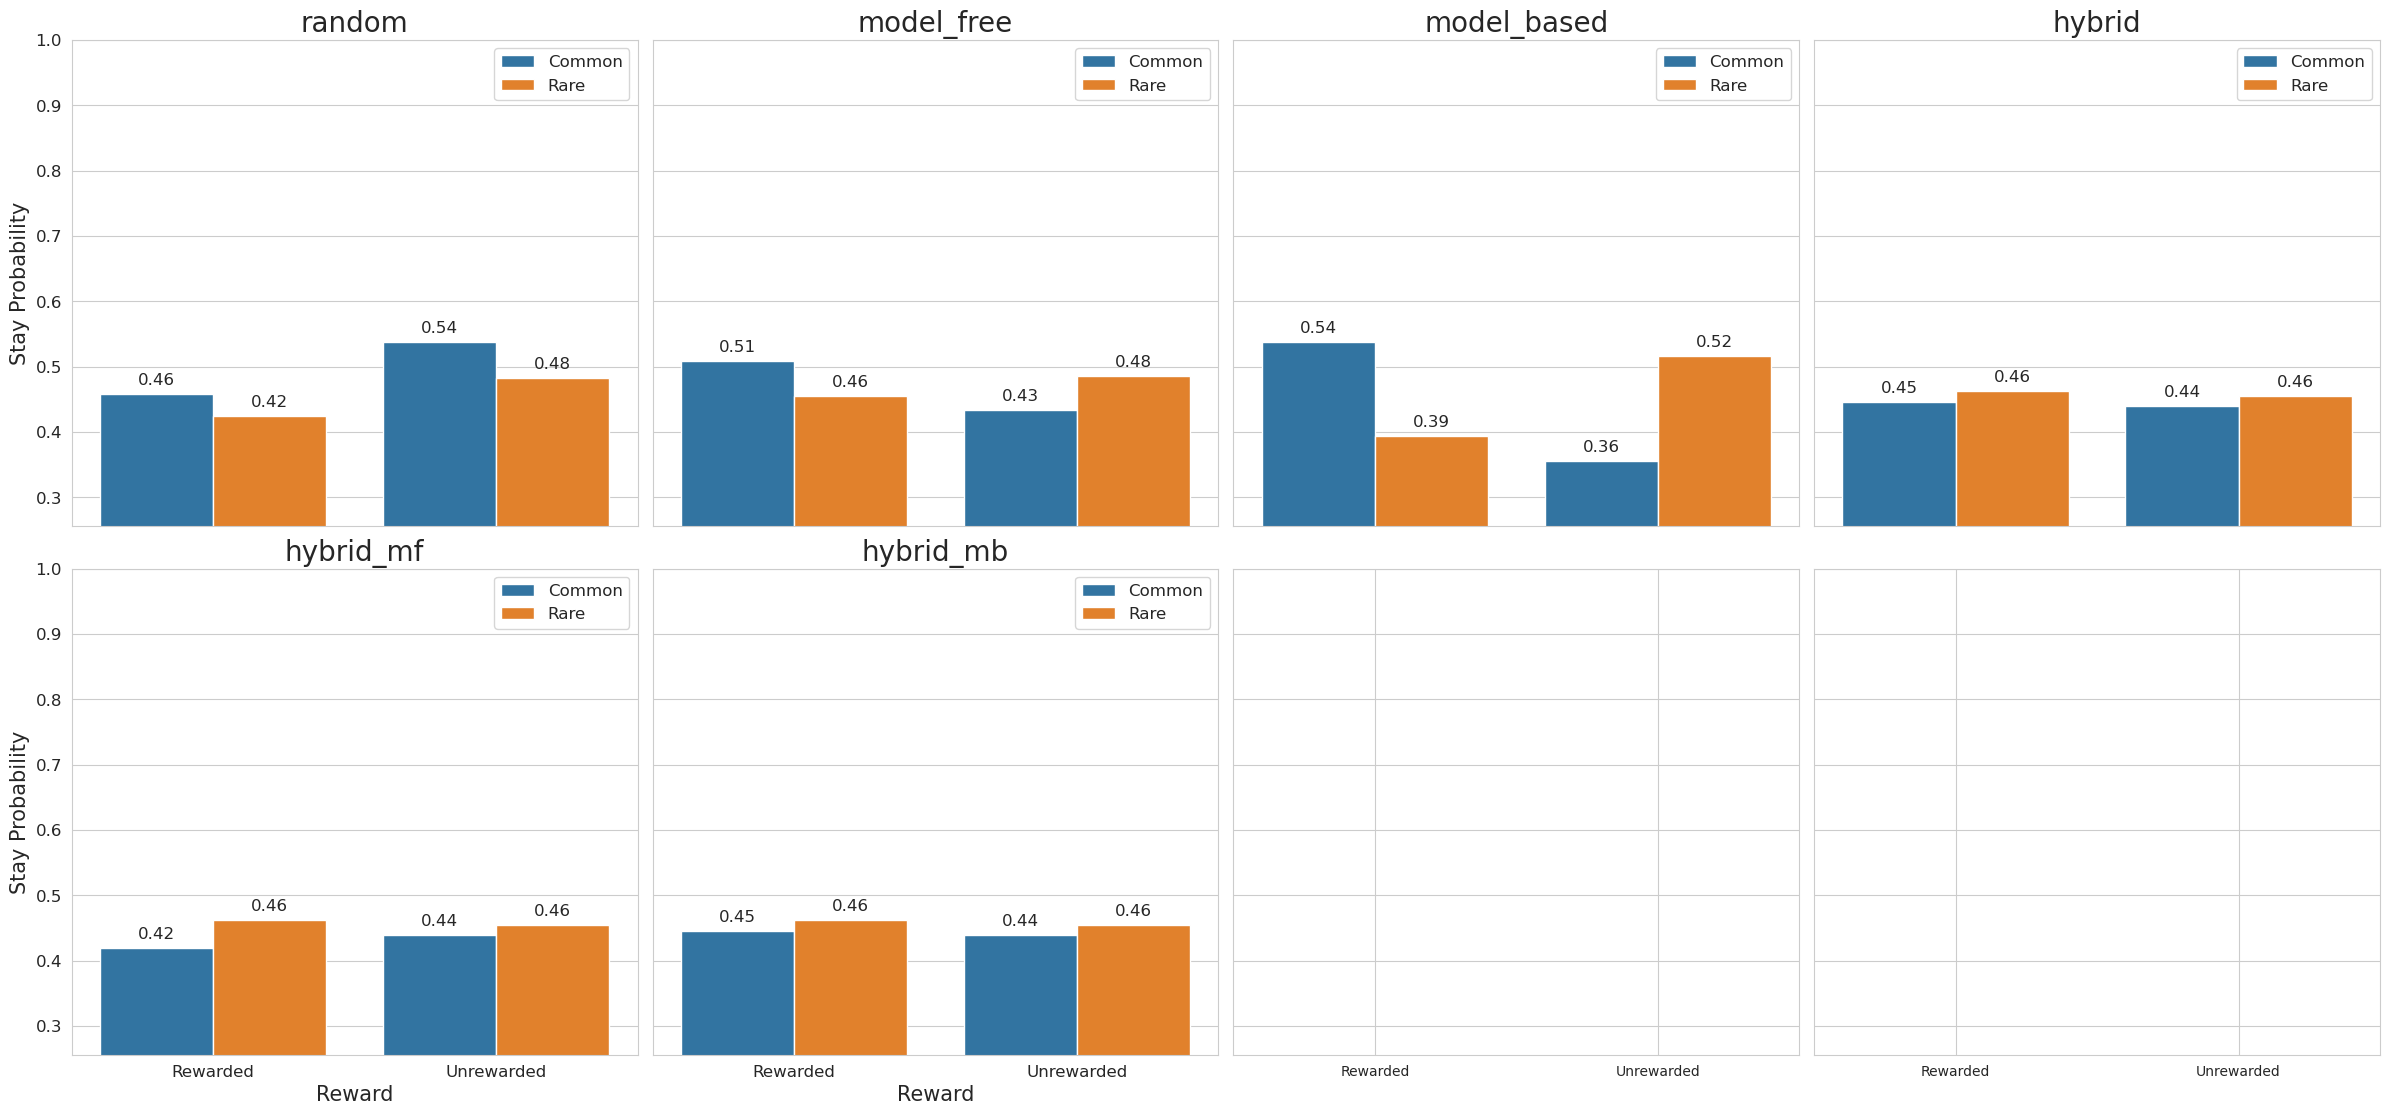

In [98]:

# print q table and transition matrix
# print("q_table model free:\n", agent_mf.q_table)
# print("q_table model based:\n", agent_mb.q_table)
# print("q_table hybrid:\n", agent_hybrid.q_table)
# print("q_table hybrid mf:\n", agent_hybrid_mf.q_table)
# print("q_table hybrid mb:\n", agent_hybrid_mb.q_table)

# if hasattr(agent_mb, 'transition_model'):
#     print("transition_matrix model based:\n", agent_mb.transition_model[0])
# if hasattr(agent_hybrid, 'transition_model'):
#     print("transition_matrix hybrid:\n", agent_hybrid.transition_model[0])
# if hasattr(agent_hybrid_mf, 'transition_model'):
#     print("transition_matrix hybrid mf:\n", agent_hybrid_mf.transition_model[0])
# if hasattr(agent_hybrid_mb, 'transition_model'):
#     print("transition_matrix hybrid mb:\n", agent_hybrid_mb.transition_model[0])

# print some statistics 
print_simple_statistics(task_df_r, title='random')
print_simple_statistics(task_df_mf, title='model_free')
print_simple_statistics(task_df_mb, title='model_based')
print_simple_statistics(task_df_hybrid, title='hybrid')
print_simple_statistics(task_df_hybrid_mf, title='hybrid_mf')
print_simple_statistics(task_df_hybrid_mb, title='hybrid_mb')

# calculate and plot stay probability
stay_probability_r, _ = calculate_stay_probability(task_df_r)
stay_probability_mf, _ = calculate_stay_probability(task_df_mf)
stay_probability_mb, _ = calculate_stay_probability(task_df_mb)
stay_probability_hybrid, _ = calculate_stay_probability(task_df_hybrid)
stay_probability_hybrid_mf, _ = calculate_stay_probability(task_df_hybrid_mf)
stay_probability_hybrid_mb, _ = calculate_stay_probability(task_df_hybrid_mb)

fig = plot_stay_probabilities(dfs=[stay_probability_r,
                            stay_probability_mf,
                            stay_probability_mb,
                             stay_probability_hybrid,
                             stay_probability_hybrid_mf,
                             stay_probability_hybrid_mb],
                        labels=['random',
                                'model_free',
                                'model_based',
                                'hybrid',
                                'hybrid_mf',
                                'hybrid_mb'])

# display(task_df_extended[['stepOneChoice', 'repeated_stepOneAction', 'repeated_stepOneAction_next','reward', 'common_transition']])


## Model Simulation *(3 points)*

For this exercise you should:

*   Simulate data from both models for a single set of parameters. The simulation should mimic the experiment you are trying to model. *(2 points)*

*   Plot the simulated behavior of both models. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.


In [99]:
from simulate import simulate
from utils import calculate_running_step_probabilities, plot_running_step_probabilities,\
     preprocess_human_data, calculate_stay_probability, plot_stay_probabilities,\
        print_simple_statistics, save_simulated_data
import pandas as pd
import os

In [100]:
# parameters
params_model_free = {'alpha': 0.2,
                      'beta': 3,
                      'gamma': 0.9}
params_model_based = {'alpha': 0.2,
                      'beta': 3,
                      'gamma': 0.9}
params_hybrid = {'alpha_1': 0.2,
                 'alpha_2': 0.2,
                 'beta_1': 3,
                 'beta_2': 3,
                 '_lambda': 0,
                 'w': 0.5,
                 'p': 0.2}
params_hybrid_mf = {'alpha_1': 0.2,
                    'alpha_2': 0.2,
                    'beta_1': 3,
                    'beta_2': 3,
                    '_lambda': 0,
                    'w': 0,
                    'p': 0.2}
params_hybrid_mb = {'alpha_1': 0.2,
                    'alpha_2': 0.2,
                    'beta_1': 3,
                    'beta_2': 3,
                    '_lambda': 0,
                    'w': 1,
                    'p': 0.2}

# Run simulation and save to csv
task_df_mf, agent_mf = simulate(agent_type='model_free', params=params_model_free)
task_df_mb, agent_mb = simulate(agent_type='model_based', params=params_model_based)
task_df_hybrid, agent_hybrid = simulate(agent_type='hybrid', params=params_hybrid)
task_df_hybrid_mf, agent_hybrid_mf = simulate(agent_type='hybrid', params=params_hybrid_mf)
task_df_hybrid_mb, agent_hybrid_mb = simulate(agent_type='hybrid', params=params_hybrid_mb)
# task_df_random, agent_random = simulate(agent_type='random')
# save_simulated_data(task_df_mf, agent_type='model_free')
# save_simulated_data(task_df_mb, agent_type='model_based')
# save_simulated_data(task_df_hybrid, agent_type='hybrid')
# save_simulated_data(task_df_hybrid_mf, agent_type='hybrid_mf')
# save_simulated_data(task_df_hybrid_mb, agent_type='hybrid_mb')

# load and inspect human data
particepant_data_file = "experiment_data_mj.csv"
file_name = os.path.join("data", "participants", particepant_data_file)
human_data = pd.read_csv(file_name)
# preprocess human data
human_data = preprocess_human_data(human_data)

### Model Free
common transitions percentage: 72.5 %
rewarded trails percentage: 43.0 %
### Model Based
common transitions percentage: 68.0 %
rewarded trails percentage: 48.5 %
### Hybrid
common transitions percentage: 71.0 %
rewarded trails percentage: 54.0 %
### Participant
common transitions percentage: 70.5 %
rewarded trails percentage: 56.99999999999999 %
### Hybrid MF
common transitions percentage: 69.5 %
rewarded trails percentage: 54.0 %
### Hybrid MB
common transitions percentage: 70.0 %
rewarded trails percentage: 55.00000000000001 %


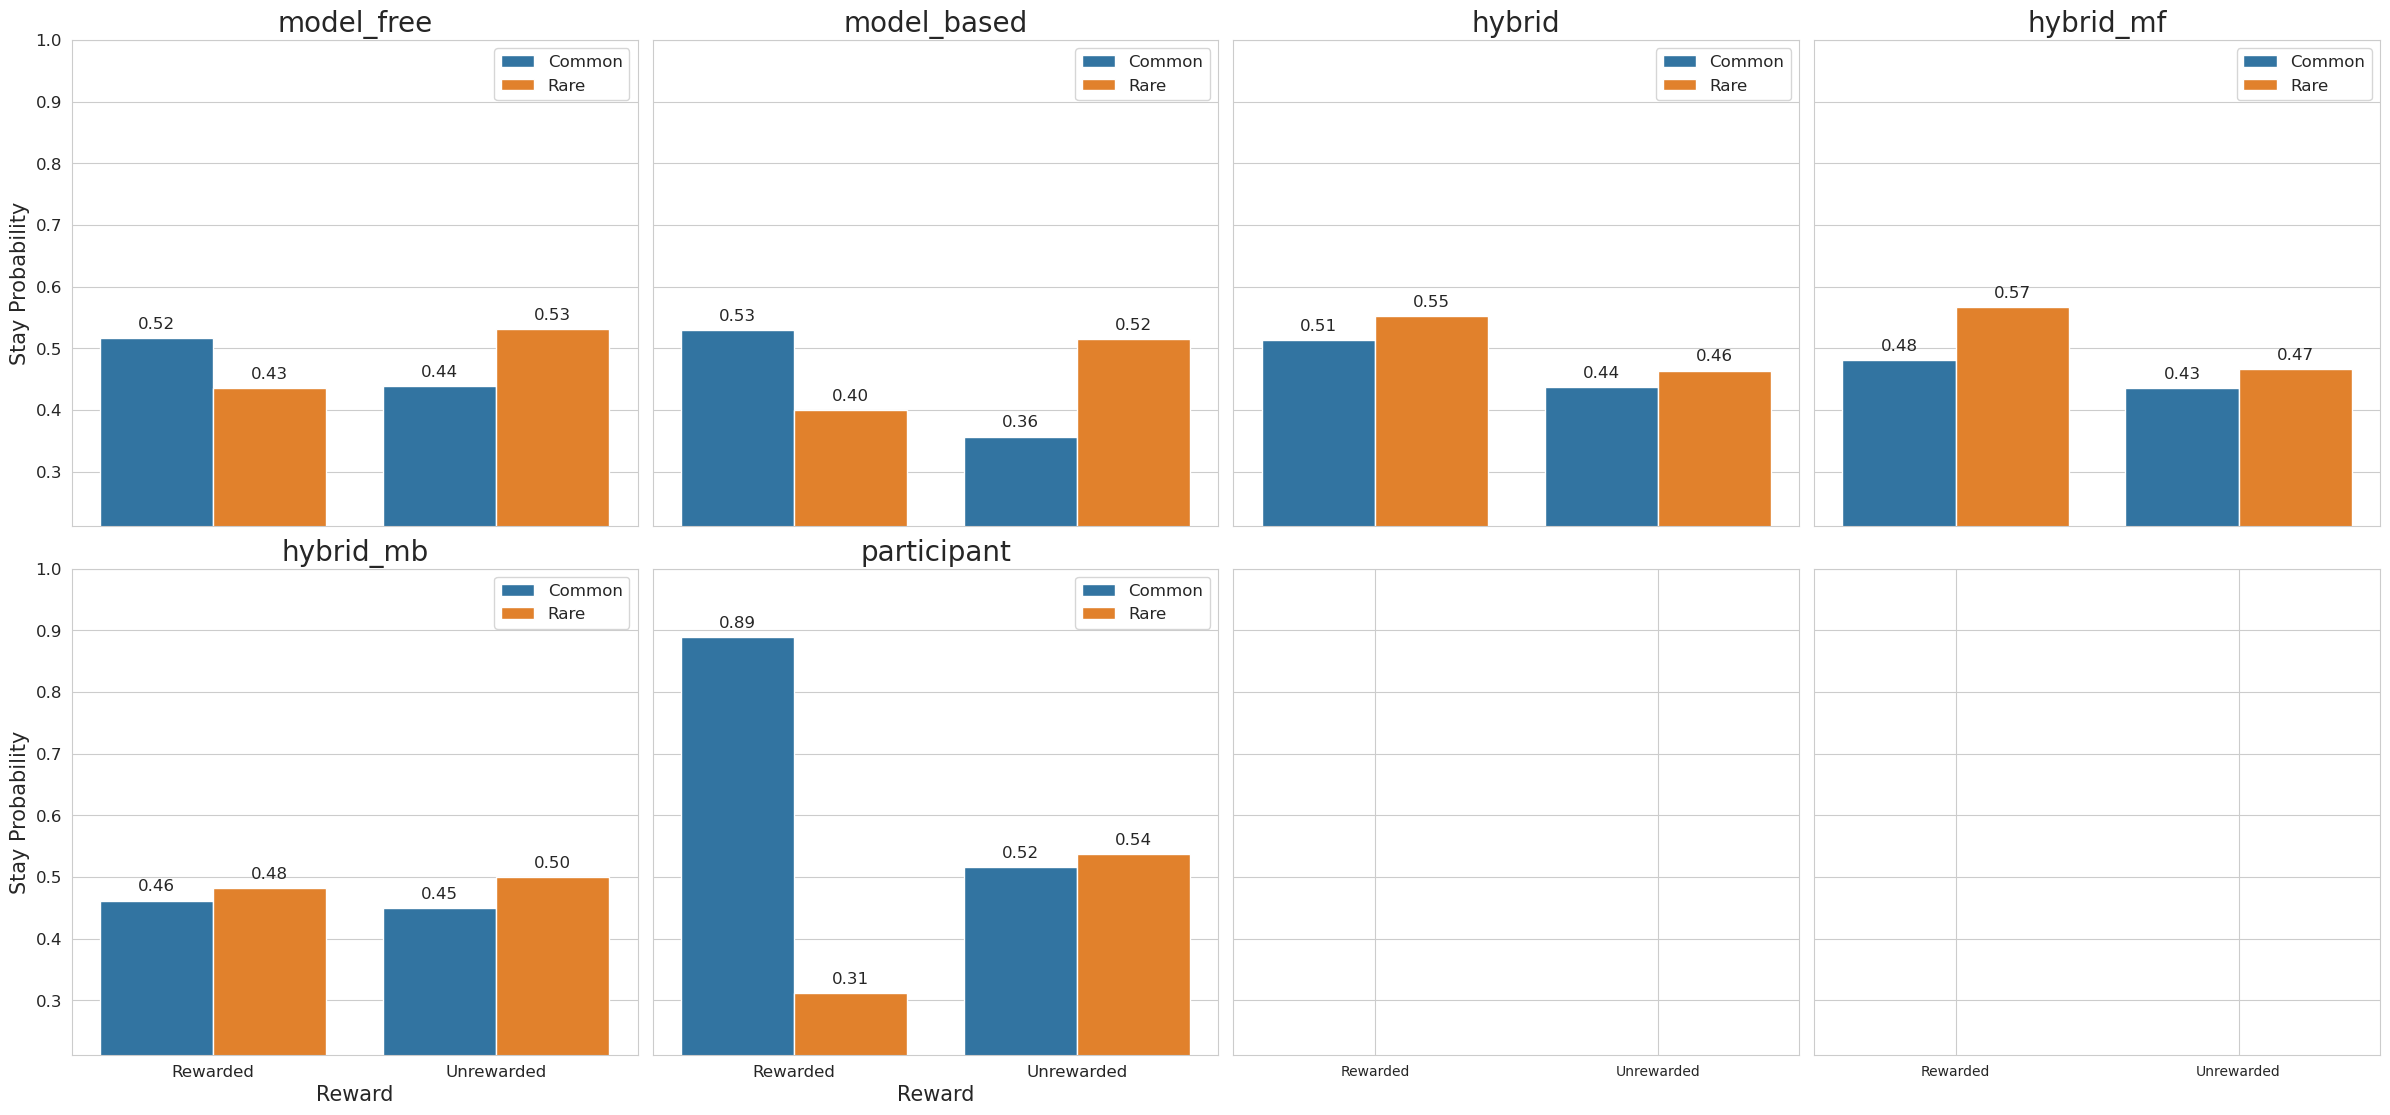

In [101]:
# print some statistics 
print_simple_statistics(task_df_mf, title='Model Free')
print_simple_statistics(task_df_mb, title='Model Based')
print_simple_statistics(task_df_hybrid, title='Hybrid')
print_simple_statistics(human_data, title='Participant')
print_simple_statistics(task_df_hybrid_mf, title='Hybrid MF')
print_simple_statistics(task_df_hybrid_mb, title='Hybrid MB')

# calculate and plot stay probability
stay_probability_mf, _ = calculate_stay_probability(task_df_mf)
stay_probability_mb, _ = calculate_stay_probability(task_df_mb)
stay_probability_h, _ = calculate_stay_probability(human_data)
stay_probability_hybrid, _ = calculate_stay_probability(task_df_hybrid)
stay_probability_hybrid_mf, _ = calculate_stay_probability(task_df_hybrid_mf)
stay_probability_hybrid_mb, _ = calculate_stay_probability(task_df_hybrid_mb)

plot_stay_probabilities(dfs=[stay_probability_mf, 
                            stay_probability_mb, 
                            stay_probability_hybrid,
                            stay_probability_hybrid_mf,
                            stay_probability_hybrid_mb,
                            stay_probability_h],
                        labels=['model_free', 'model_based', 'hybrid', 'hybrid_mf', 'hybrid_mb', 'participant'])

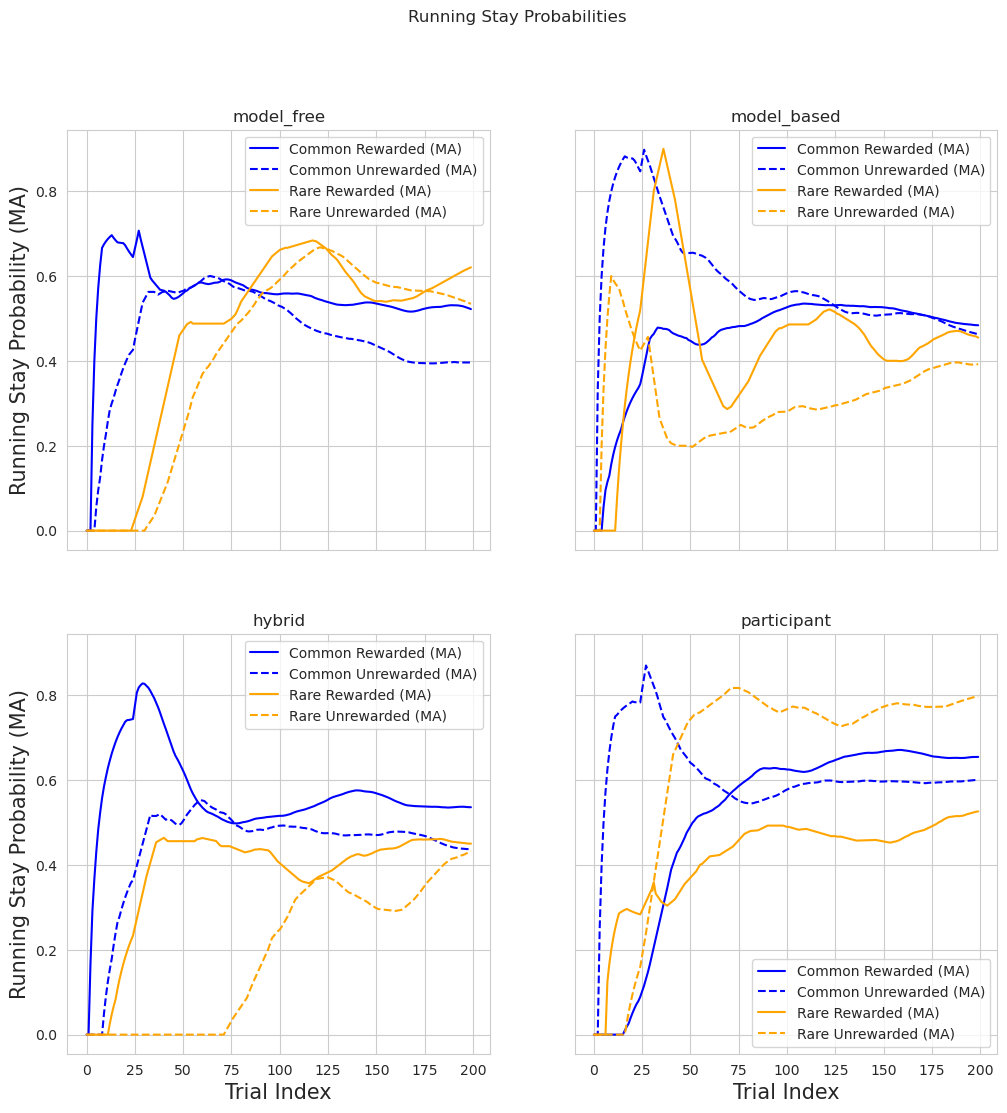

In [102]:
AVERAGE_WINDOW = 25
                      
# Generate behavior from the model free agent
task_df_mf = calculate_running_step_probabilities(task_df_mf)

# Generate behavior from the model based agent
task_df_mb = calculate_running_step_probabilities(task_df_mb)

# Generate behavior from the hybrid agent
task_df_hybrid = calculate_running_step_probabilities(task_df_hybrid)

# Generate behavior from the human data
human_data = calculate_running_step_probabilities(human_data)

# plot the running step probabilities
plot_running_step_probabilities(task_dfs=[task_df_mf, task_df_mb, task_df_hybrid, human_data],
                               labels=['model_free', 'model_based', 'hybrid', 'participant'],
                                window_size=AVERAGE_WINDOW, title='Running Stay Probabilities',
                                max_plots_per_row=2)

## Parameter Fitting *(4 points)*

For this exercise you should:

*   Set up a suitable parameter search space *(1 point)*

*   Implement a procedure to evaluate the fit of a model based on data *(2 points)*

*   Implement a procedure for searching the parameter space. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.



In [103]:
from simulate import simulate
from parameter_fitting import fit_with_grid_search, fit_to_average_accumulated_reward, plot_fit_results,\
    fit_with_random_search, get_best_params_and_ll, fit_with_minimize
from utils import preprocess_human_data, calculate_stay_probability, plot_stay_probabilities, print_simple_statistics,\
    calculate_and_plot_diffs, calculate_running_step_probabilities, plot_running_step_probabilities
import numpy as np
import pandas as pd
import os
from scipy.stats import uniform
from IPython.display import display
from tqdm import tqdm

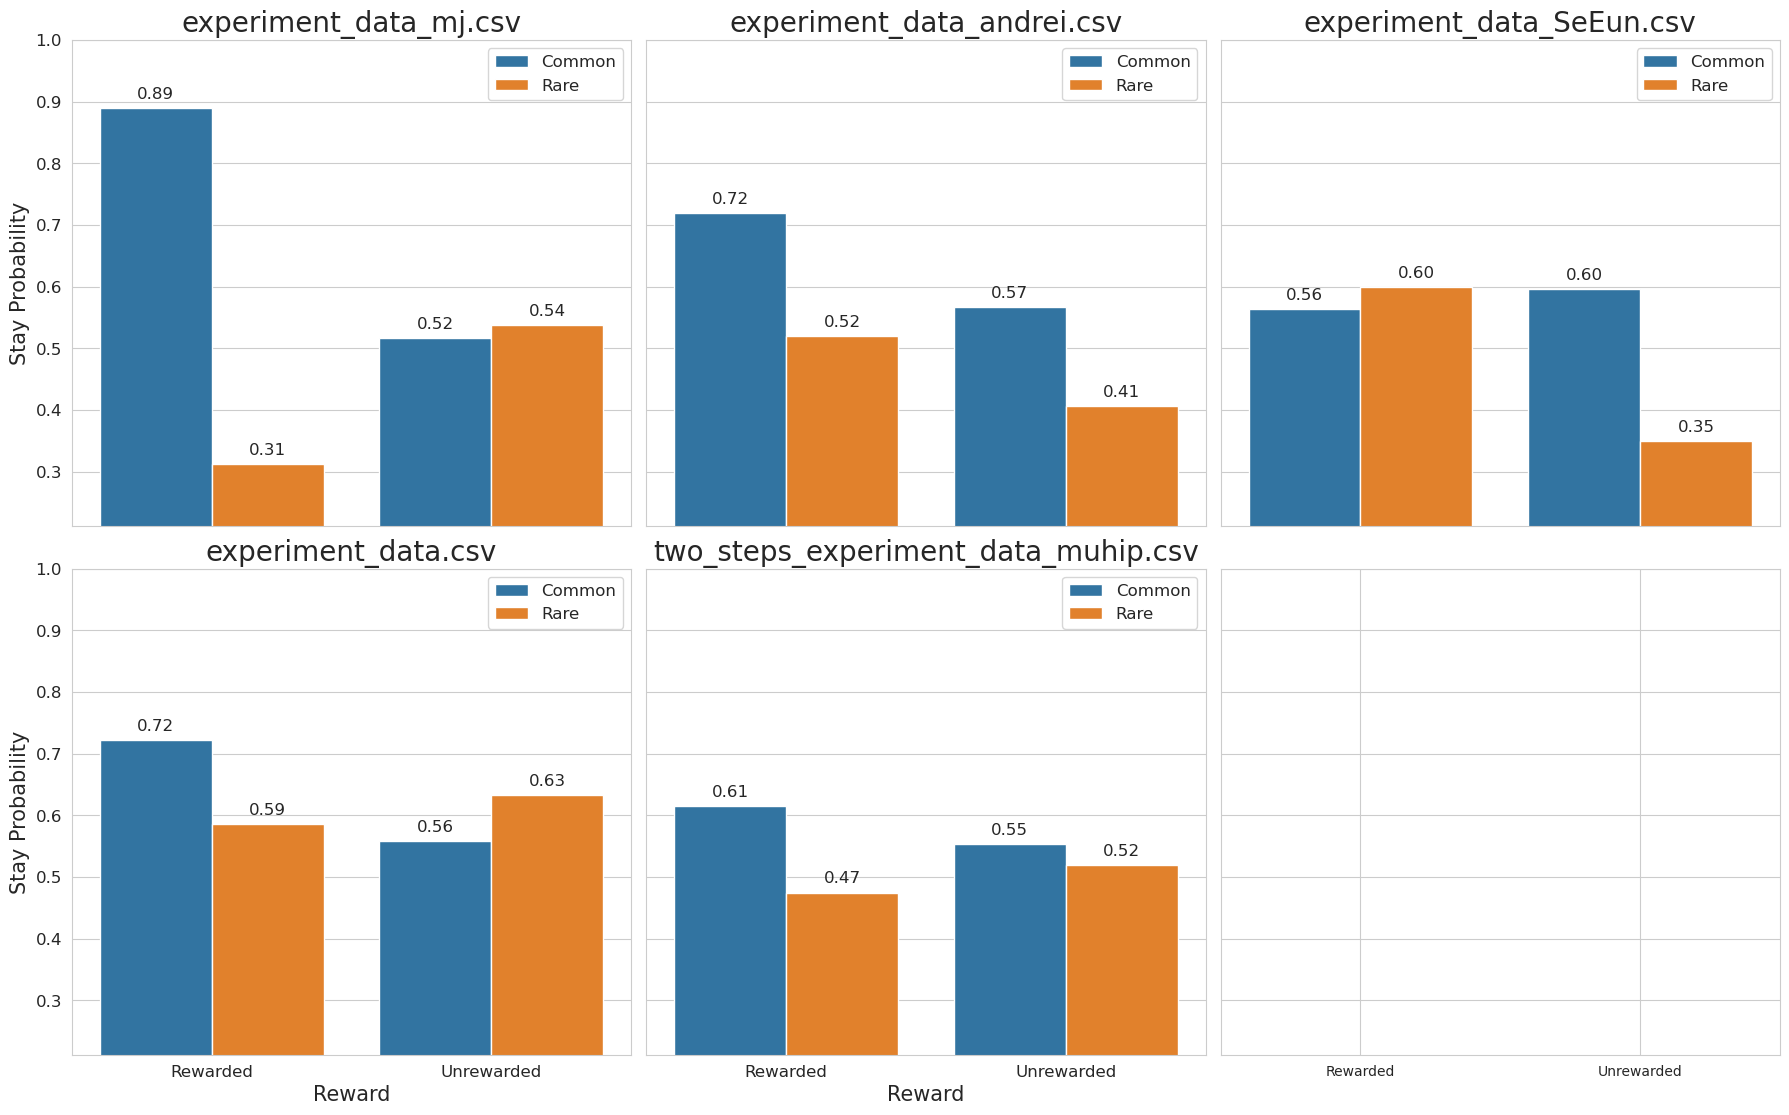

In [104]:
# load and inspect some human data
file_names = ['experiment_data_mj.csv', 'experiment_data_andrei.csv', 
              'experiment_data_SeEun.csv', 'experiment_data.csv', 'two_steps_experiment_data_muhip.csv']
stay_prob_list = []
human_data_list = [] 
for file_name in file_names:
    file_name = os.path.join("data", "participants", file_name)
    human_data = pd.read_csv(file_name)
    human_data = preprocess_human_data(human_data)
    human_data_list.append(human_data)
    
    stay_probability_h, _ = calculate_stay_probability(human_data)
    stay_prob_list.append(stay_probability_h)

plot_stay_probabilities(dfs=stay_prob_list, labels=file_names, max_plots_per_row=3)

In [131]:
# pick a participant to fit the model to
data = human_data_list[0]

NUM_ITERATIONS = 256  # Number of iterations for random search
NUM_INITILIZATIONS = 10  # Number of random initializations for minimize search
CONSIDER_BOTH_STAGES = True
kwargs_for_fitting_functions = {'num_iterations': NUM_ITERATIONS,
                                'num_initializations': NUM_INITILIZATIONS,
                                'consider_both_stages': CONSIDER_BOTH_STAGES}

INTERPOLATION_STEPS = 21 # Number of steps for interpolation of the parameter space
# define the parameter space for the simple model free and based
ALPHA_RANGE = (0.01, 0.8)
BETA_RANGE = (-4, 8)
# Define parameter distributions for hybrid model and its tow special cases (model free and model based)
ALPHA_1_RANGE = (0.01, 0.8)
ALPHA_2_RANGE = (0.01, 0.8)
BETA_1_RANGE = (-4, 8)
BETA_2_RANGE = (-4, 8)
LAMBDA_RANGE = (0, 1)
W_RANGE = (0, 1)
P_RANGE = (-2, 2)

alpha_space = np.linspace(*ALPHA_RANGE, INTERPOLATION_STEPS)
beta_space = np.linspace(*BETA_RANGE, INTERPOLATION_STEPS)
# for grid search and minimize search
parammeter_space = {'alpha': alpha_space,
                    'beta': beta_space}
# for random search
param_distributions = {'alpha': uniform(ALPHA_RANGE[0], ALPHA_RANGE[1] - ALPHA_RANGE[0]),
                       'beta': uniform(BETA_RANGE[0], BETA_RANGE[1] - BETA_RANGE[0])}

# for grid search and minimize search
param_space_hybrid = {
    'alpha_1': np.linspace(*ALPHA_1_RANGE, INTERPOLATION_STEPS),
    'alpha_2': np.linspace(*ALPHA_2_RANGE, INTERPOLATION_STEPS),
    'beta_1': np.linspace(*BETA_1_RANGE, INTERPOLATION_STEPS),
    'beta_2': np.linspace(*BETA_2_RANGE, INTERPOLATION_STEPS),
    '_lambda': np.linspace(*LAMBDA_RANGE, INTERPOLATION_STEPS),
    'w': np.linspace(*W_RANGE, INTERPOLATION_STEPS),
    'p': np.linspace(*P_RANGE, INTERPOLATION_STEPS),
}
# for random search
param_distributions_hybrid = {
    'alpha_1': uniform(ALPHA_1_RANGE[0], ALPHA_1_RANGE[1] - ALPHA_1_RANGE[0]),
    'alpha_2': uniform(ALPHA_2_RANGE[0], ALPHA_2_RANGE[1] - ALPHA_2_RANGE[0]),
    'beta_1': uniform(BETA_1_RANGE[0], BETA_1_RANGE[1] - BETA_1_RANGE[0]),
    'beta_2': uniform(BETA_2_RANGE[0], BETA_2_RANGE[1] - BETA_2_RANGE[0]),
    '_lambda': uniform(LAMBDA_RANGE[0], LAMBDA_RANGE[1] - LAMBDA_RANGE[0]),
    'w': uniform(W_RANGE[0], W_RANGE[1] - W_RANGE[0]),
    'p': uniform(P_RANGE[0], P_RANGE[1] - P_RANGE[0])
}

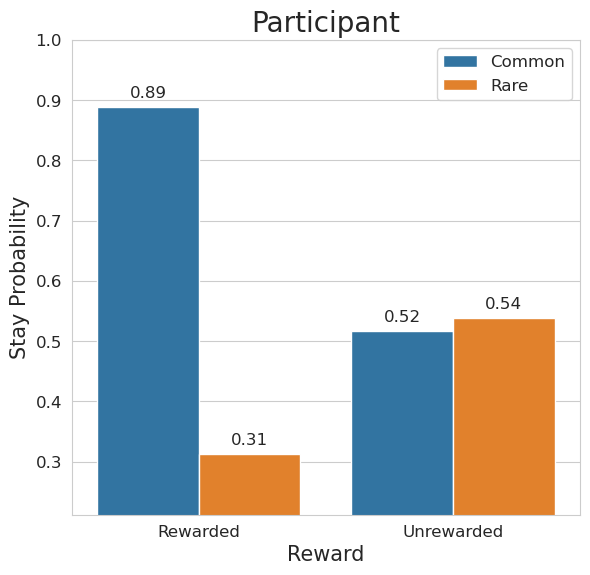

In [132]:
stay_prob_data, _ = calculate_stay_probability(data) 
plot_stay_probabilities(stay_prob_data, labels='Participant')

In [133]:
best_params_mf, best_LL_mf, fit_results_mf = fit_with_grid_search(parammeter_space, data, agent_type='model_free',
                                            consider_both_stages=CONSIDER_BOTH_STAGES)

In [134]:
best_params_mb, best_LL_mb, fit_results_mb = fit_with_grid_search(parammeter_space, data, agent_type='model_based',
                                            consider_both_stages=CONSIDER_BOTH_STAGES)

In [70]:
np.random.seed(None)
random_seed = np.random.randint(0, 1000)

best_params_hybrid, best_LL_hybrid, fit_results_hybrid = fit_with_random_search(param_space_hybrid, data, agent_type='hybrid',
                                            consider_both_stages=CONSIDER_BOTH_STAGES, num_iterations=NUM_ITERATIONS, seed=random_seed)

np.random.seed(None)

In [71]:
best_fitted_params_mf_minimize, best_LL_mf_minimize = fit_with_minimize(parammeter_space, data, 
                                                        agent_type='model_free', consider_both_stages=CONSIDER_BOTH_STAGES,
                                                        num_initializations=NUM_INITILIZATIONS)

In [72]:
best_fitted_params_mb_minimize, best_LL_mb_minimize = fit_with_minimize(parammeter_space, data,
                                                        agent_type='model_based', consider_both_stages=CONSIDER_BOTH_STAGES,
                                                        num_initializations=NUM_INITILIZATIONS)

In [73]:
best_fitted_params_hybrid_minimize, best_LL_hybrid_minimize = fit_with_minimize(param_space_hybrid, data,
                                                         agent_type='hybrid', consider_both_stages=CONSIDER_BOTH_STAGES,
                                                         num_initializations=NUM_INITILIZATIONS)

/home/martin/Uni/semester_curr/Modeling_in_CogSci/rl-twoStepTask/agents/hybrid.py:152: RuntimeWarning: overflow encountered in exp
  exp_values = np.exp(beta * (q_values + p * rep_a - np.max(q_values)))
/home/martin/Uni/semester_curr/Modeling_in_CogSci/rl-twoStepTask/agents/hybrid.py:157: RuntimeWarning: invalid value encountered in divide
  probabilities = exp_values / np.sum(exp_values)
/home/martin/Uni/semester_curr/Modeling_in_CogSci/rl-twoStepTask/parameter_fitting.py:71: RuntimeWarning: divide by zero encountered in log
  LogLikelihood_sum += np.log(chosen_action_1_prob)


In [74]:
# model free as special cases of hybrid model
param_space_hybrid_mf = param_space_hybrid.copy() 
param_space_hybrid_mf['w'] = np.array([0.0])
best_fitted_params_hybrid_mf_minimize, best_LL_hybrid_mf_minimize = fit_with_minimize(param_space_hybrid_mf, data,
                                                        agent_type='hybrid', consider_both_stages=CONSIDER_BOTH_STAGES,
                                                        num_initializations=NUM_INITILIZATIONS)

/home/martin/miniconda3/envs/m_cs/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


In [75]:
# model based as special cases of hybrid model
param_space_hybrid_mb = param_space_hybrid.copy() 
param_space_hybrid_mb['w'] = np.array([1.0])
best_fitted_params_hybrid_mb_minimize, best_LL_hybrid_mb_minimize = fit_with_minimize(param_space_hybrid_mb, data,
                                                        agent_type='hybrid', consider_both_stages=CONSIDER_BOTH_STAGES,
                                                        num_initializations=NUM_INITILIZATIONS)

In [135]:
sep = "\n"
end = "\n" + "-" * 50 + "\n"
print("### simple model free (grid search):", 'best params:', best_params_mf, "best_LL:", best_LL_mf, sep=sep, end=end)
print("### simple model based (grid search):", 'best params:', best_params_mb, "best_LL:", best_LL_mb, sep=sep, end=end)
print("### hybrid (random search):", 'best params:', best_params_hybrid, "best_LL:", best_LL_hybrid, sep=sep, end=end)
print("### simple model free (minimize):", 'best params:', best_fitted_params_mf_minimize, 
      "best_LL:", best_LL_mf_minimize, sep=sep, end=end)
print("### simple model based (minimize):", 'best params:', best_fitted_params_mb_minimize,
        "best_LL:", best_LL_mb_minimize, sep=sep, end=end)
print("### hybrid (minimize):", 'best params:', best_fitted_params_hybrid_minimize,
        "best_LL:", best_LL_hybrid_minimize, sep=sep, end=end)
print("### hybrid model free (w = 0) (minimize):", 'best params:', best_fitted_params_hybrid_mf_minimize,
        "best_LL:", best_LL_hybrid_mf_minimize, sep=sep, end=end)
print("### hybrid model based (w = 1) (minimize):", 'best params:', best_fitted_params_hybrid_mb_minimize,
        "best_LL:", best_LL_hybrid_mb_minimize, sep=sep, end=end)


### simple model free (grid search):
best params:
{'alpha': 0.20600000000000002, 'beta': 4.4}
best_LL:
-243.08553389454462
--------------------------------------------------
### simple model based (grid search):
best params:
{'alpha': 0.15700000000000003, 'beta': 3.8}
best_LL:
-245.65541071224425
--------------------------------------------------
### hybrid (random search):
best params:
{'w': 1.0, 'p': 0.050000000000000044, 'beta_2': -1.0, 'beta_1': 3.0, 'alpha_2': 0.0, 'alpha_1': 0.2, '_lambda': 1.0}
best_LL:
-273.843035802667
--------------------------------------------------
### simple model free (minimize):
best params:
{'alpha': 0.5, 'beta': -0.15550510708142345}
best_LL:
-277.2525556111424
--------------------------------------------------
### simple model based (minimize):
best params:
{'alpha': 0.915799259304761, 'beta': -0.3538317510849445}
best_LL:
-275.08987109862795
--------------------------------------------------
### hybrid (minimize):
best params:
{'alpha_1': 0.5, 'alph

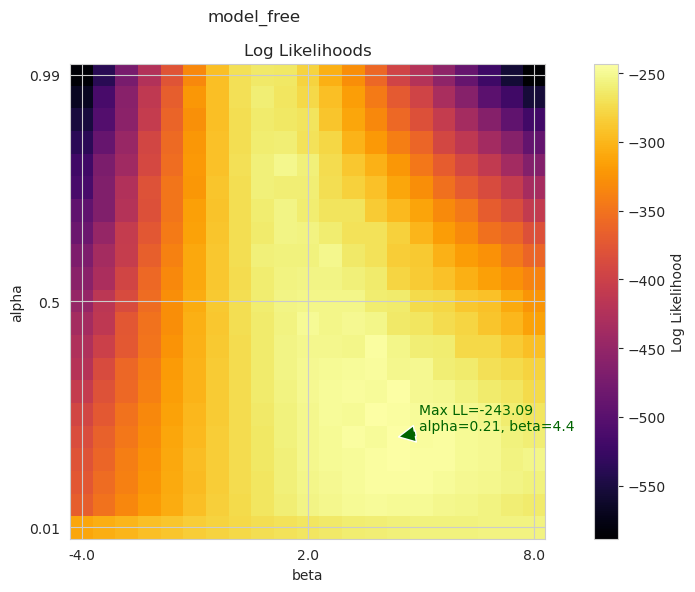

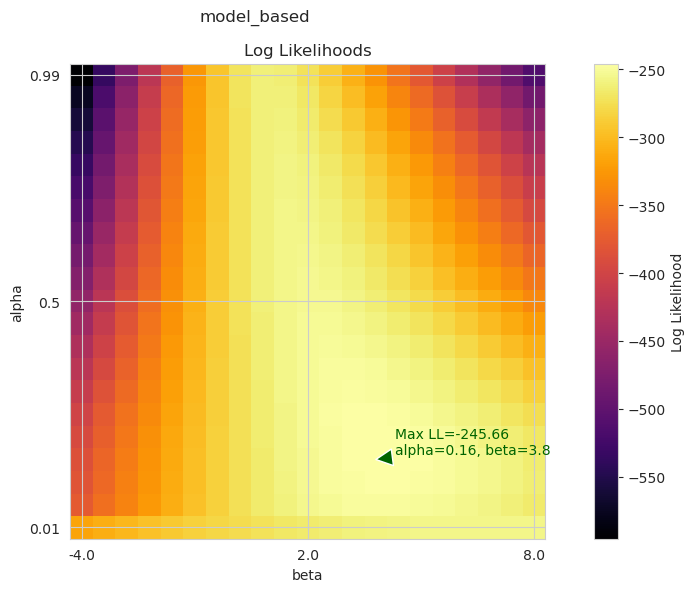

In [136]:
# plot fit results
plot_fit_results(fit_results_mf, parammeter_space, title='model_free')
plot_fit_results(fit_results_mb, parammeter_space, title='model_based')

In [118]:
# simualte moltiple times and concatenate the data to average the results
# model_type = 'model_based'
# if model_type == 'model_based':
#     best_params = best_params_mb
# elif model_type == 'model_free':
#     best_params = best_params_mf
# else:
#     print('model type not recognized')

sample_size = 100
sampled_data_mf = []
sampled_data_mb = []
sampled_data_hybrid = []
sampled_data_hybrid_mf = []
sampled_data_hybrid_mb = []
random_seeds = np.random.randint(100 + sample_size ** 2, size=sample_size)
print('random_seeds:', random_seeds)
for seed in tqdm(random_seeds, desc='Simulating samples'):
    data_best_mf, _  = simulate('model_free', seed=seed, params=best_params_mf)
    data_best_mb, _ = simulate('model_based', seed=seed, params=best_params_mb)
    data_best_hybrid, _  = simulate('hybrid', seed=seed, params=best_params_hybrid)
    data_best_hybrid_mf, _  = simulate('hybrid', seed=seed, params=best_fitted_params_hybrid_mf_minimize)
    data_best_hybrid_mb, _  = simulate('hybrid', seed=seed, params=best_fitted_params_hybrid_mb_minimize)

    # print some statistics 
    # print_simple_statistics(data_best_mf, title='model_free')
    # print_simple_statistics(data_best_mb, title='model_based')
    # print_simple_statistics(data_best_hybrid, title='hybrid')
    # print_simple_statistics(data_best_hybrid_mf, title='hybrid_mf')
    # print_simple_statistics(data_best_hybrid_mb, title='hybrid_mb')

    # calculate and plot stay probability
    stay_probability_df_mf, _ = calculate_stay_probability(data_best_mf)
    stay_probability_df_mb, _ = calculate_stay_probability(data_best_mb)
    stay_probability_df_hybrid, _ = calculate_stay_probability(data_best_hybrid)
    stay_probability_df_hybrid_mf, _ = calculate_stay_probability(data_best_hybrid_mf)
    stay_probability_df_hybrid_mb, _ = calculate_stay_probability(data_best_hybrid_mb)
    # add to the data
    sampled_data_mf.append(stay_probability_df_mf)
    sampled_data_mb.append(stay_probability_df_mb)
    sampled_data_hybrid.append(stay_probability_df_hybrid)
    sampled_data_hybrid_mf.append(stay_probability_df_hybrid_mf)
    sampled_data_hybrid_mb.append(stay_probability_df_hybrid_mb)

random_seeds: [ 2171  3098  7219  1148  5522  9120   536  9453  6252   168  1810  4315
   184  5482  3356  3745  2037  2610   209  5050  9128  7225  1637  9313
  1332  1384  9157  7693  7570  7447  6115  5484  5777  3989  4654  7841
  8825  9682   879  7011  3325  3235  9113  9175  2782  7143  7409  2440
  8177  2045   815  1932  3014  3683  2859  7449  4508  6214  9102  5599
  5463  8141  1229  6264  6030  4902   296  7114  2173  2337  1878  3489
  4359   853  3888   366  9127  8923  3579  5125  8187  1170  3496  9166
  9510 10039  1098  4021  9951  8382  3201  8396  7172  3038  3883  2421
    46  7140  9204   573]


Simulating samples: 100%|██████████| 100/100 [00:21<00:00,  4.74it/s]


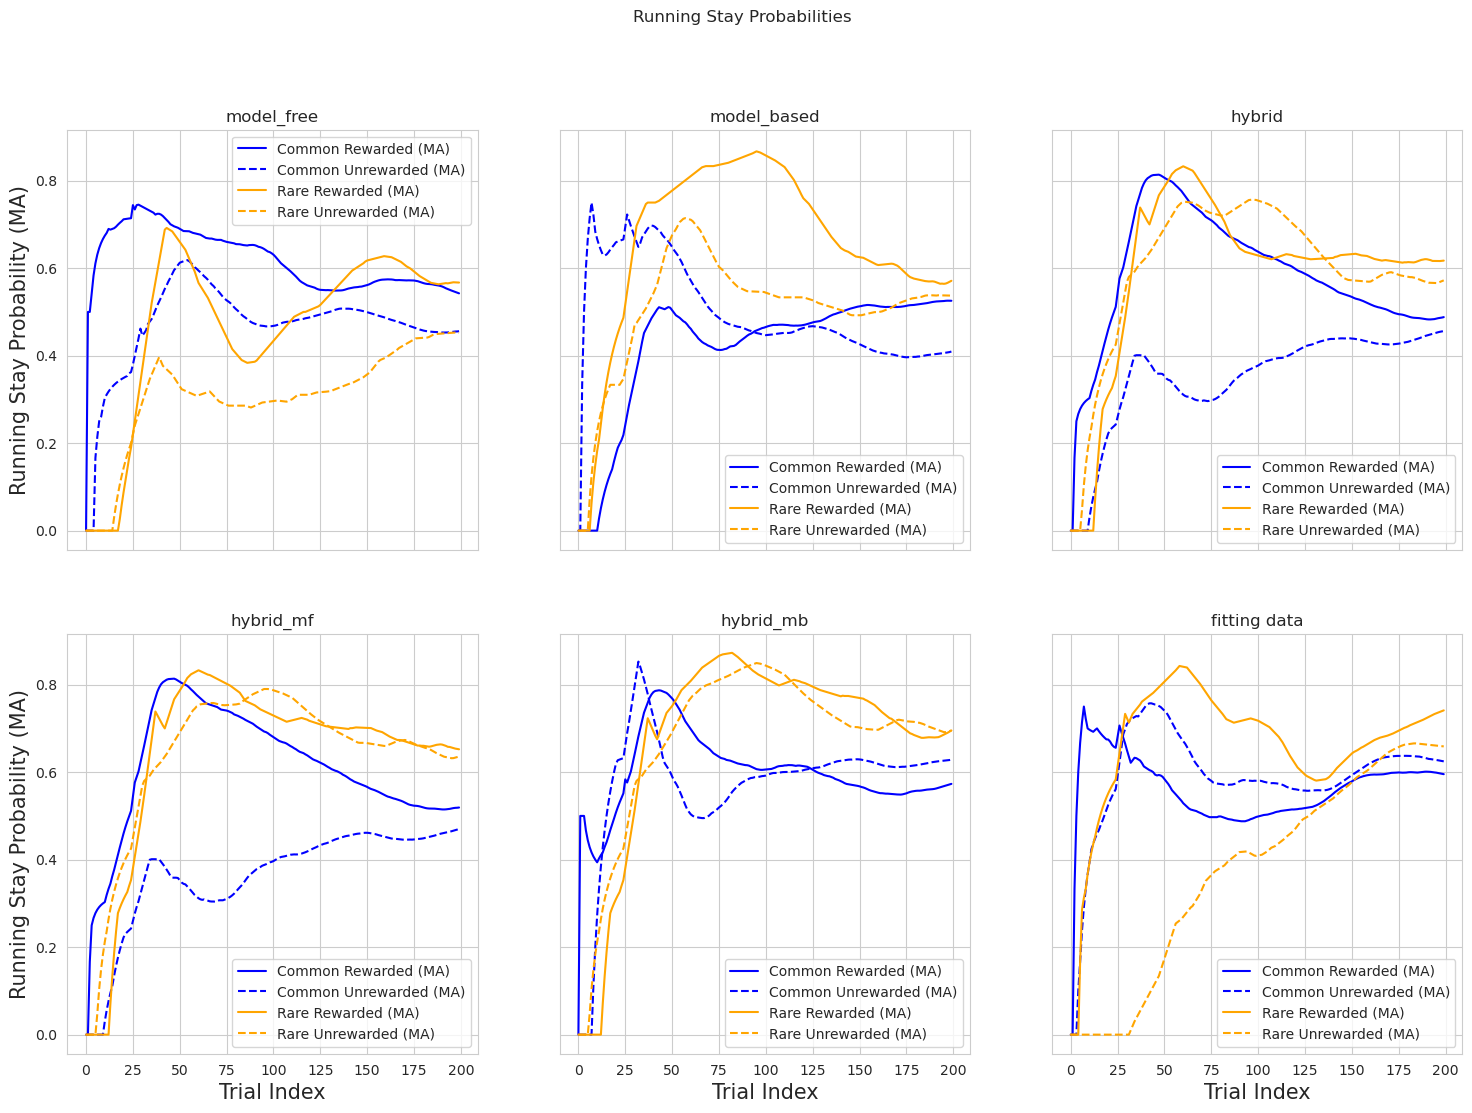

In [79]:
# plot fited models behavior
data_best_mf = calculate_running_step_probabilities(data_best_mf)
data_best_mb = calculate_running_step_probabilities(data_best_mb)
data_best_hybrid = calculate_running_step_probabilities(data_best_hybrid)
data_best_hybrid_mf = calculate_running_step_probabilities(data_best_hybrid_mf)
data_best_hybrid_mb = calculate_running_step_probabilities(data_best_hybrid_mb)
data = calculate_running_step_probabilities(data)

plot_running_step_probabilities([data_best_mf, data_best_mb, data_best_hybrid, data_best_hybrid_mf, data_best_hybrid_mb, data],
                                [ 'model_free', 'model_based', 'hybrid', 'hybrid_mf', 'hybrid_mb', 'fitting data'],
                                window_size=25, title='Running Stay Probabilities', max_plots_per_row=3)

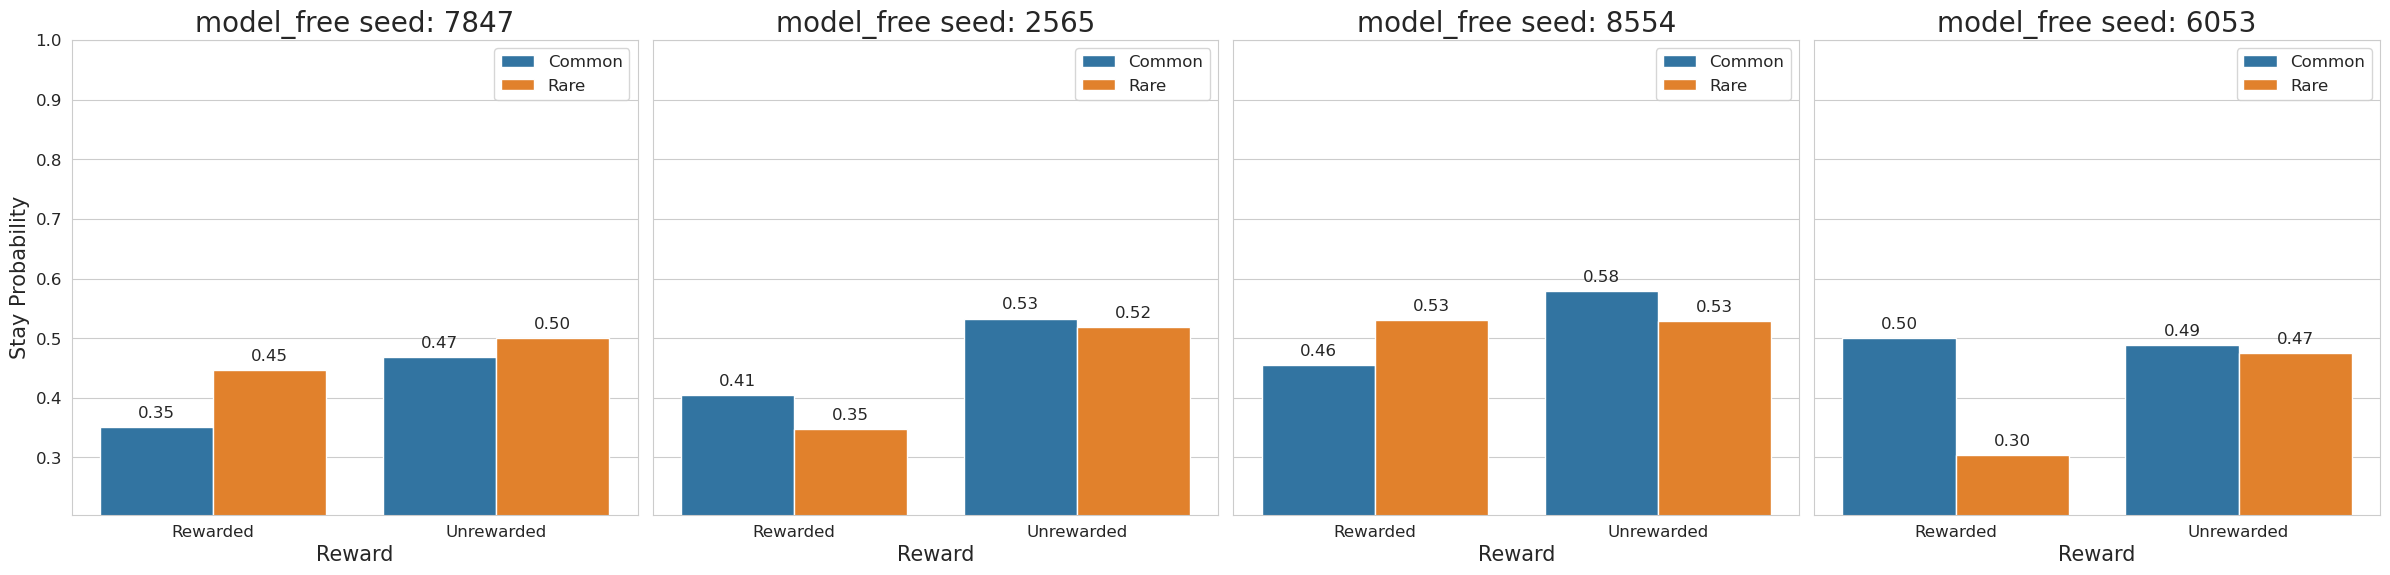

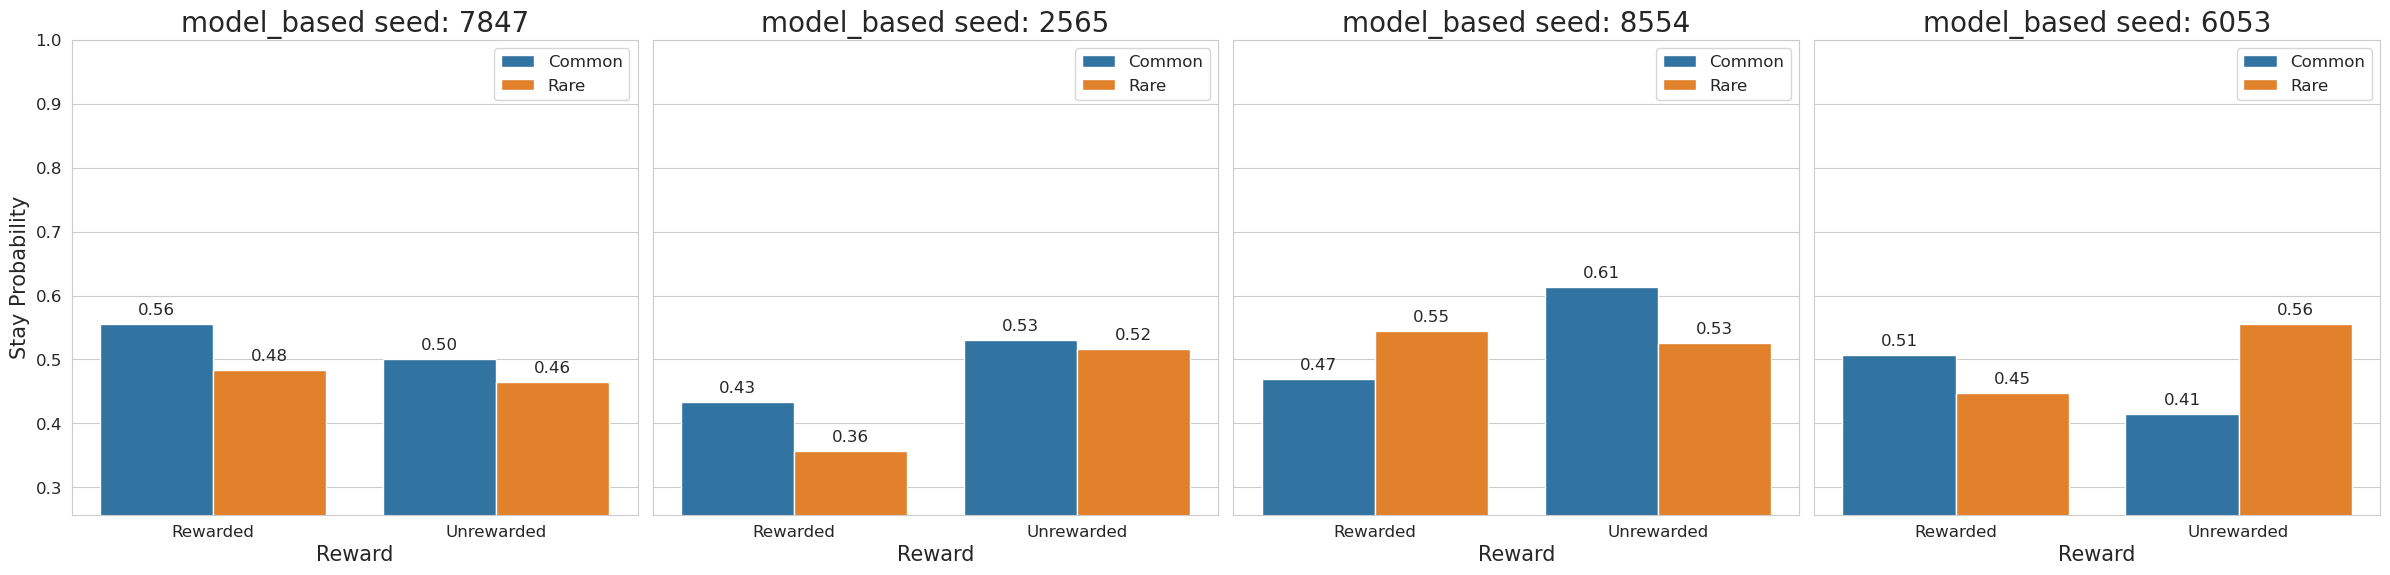

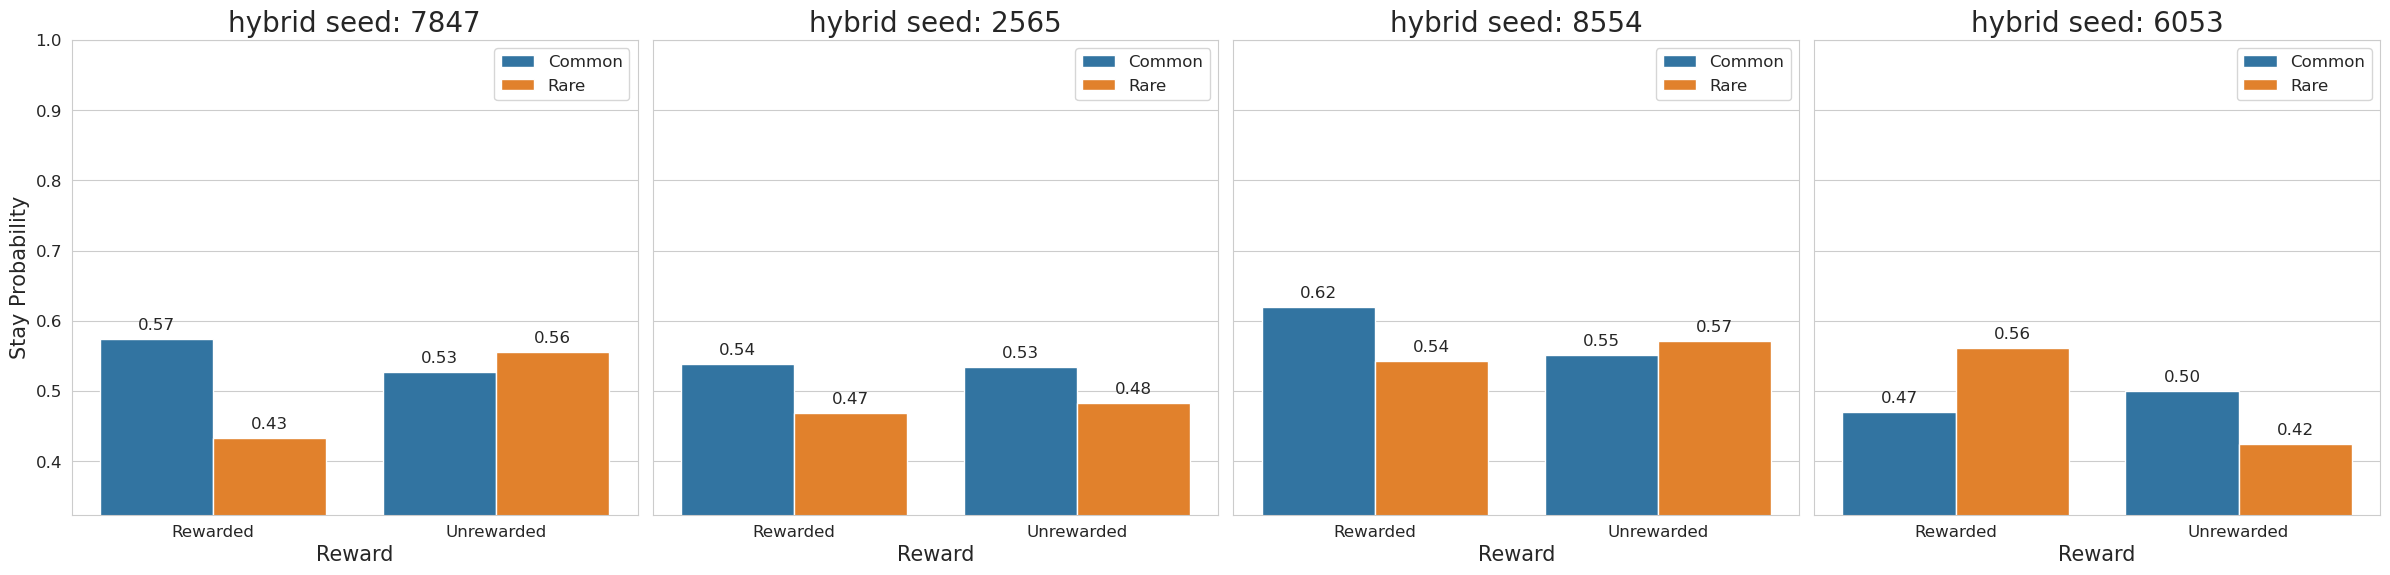

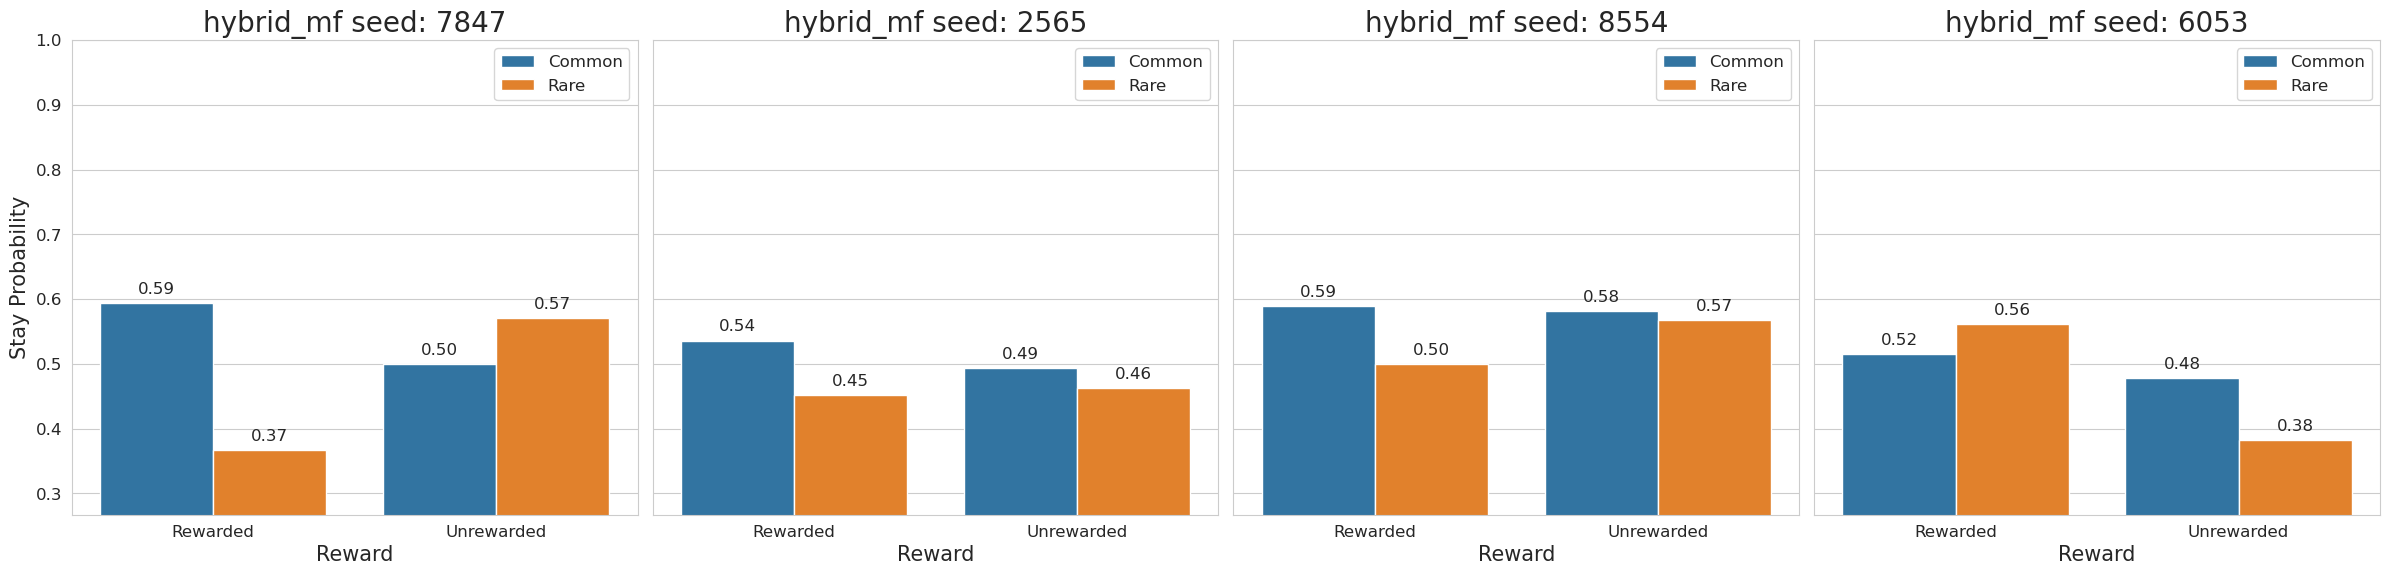

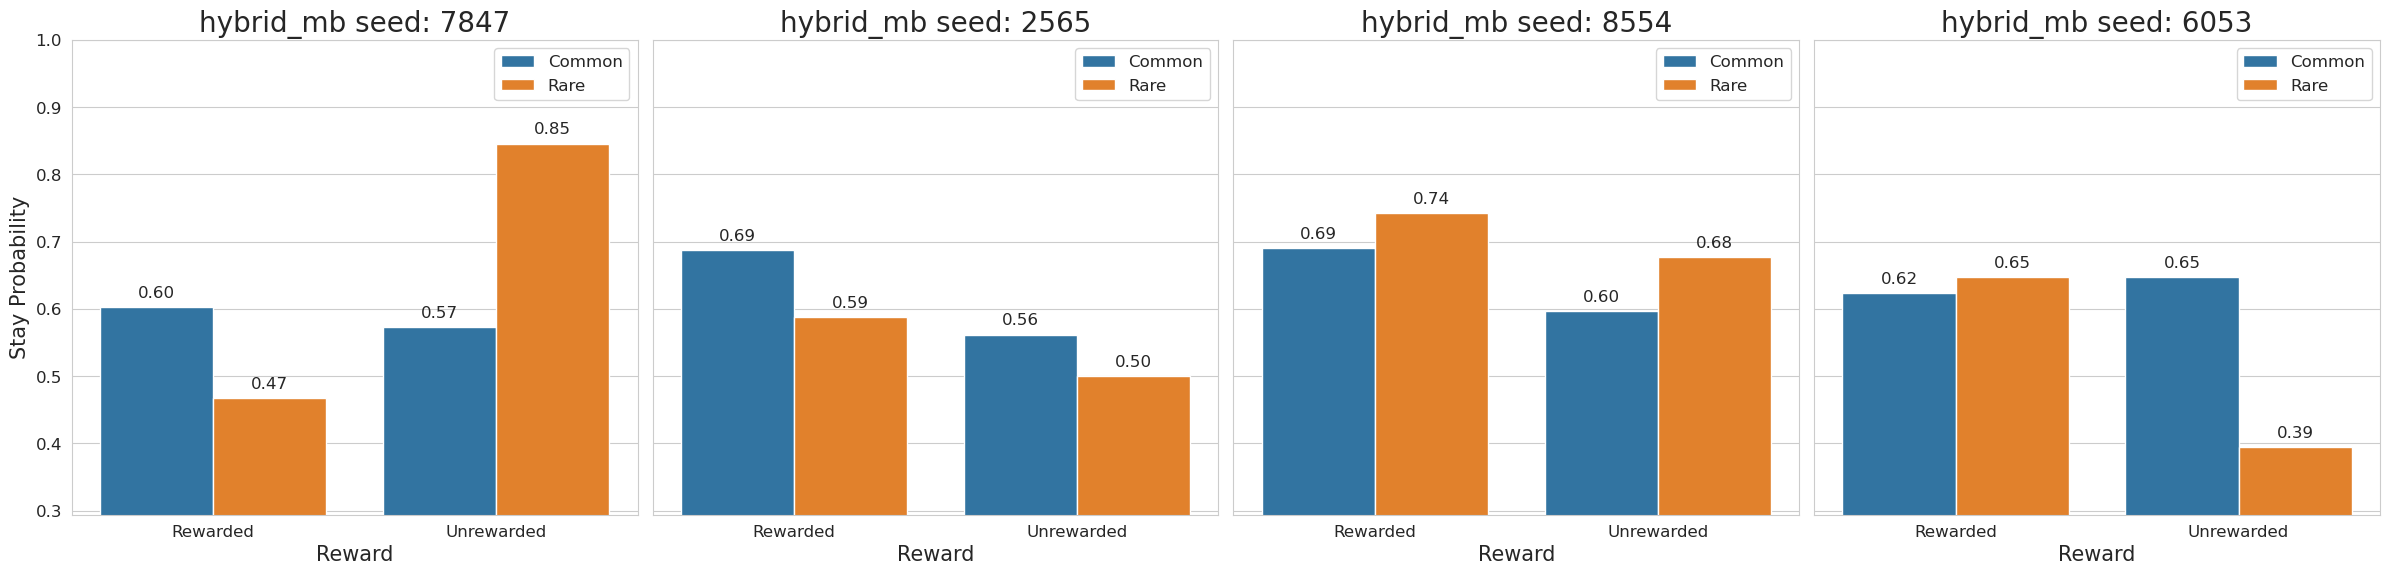

In [80]:
show_n = 4
plot_stay_probabilities(dfs=sampled_data_mf[::sample_size//show_n],
                        labels=[f'{"model_free"} seed: {s}' for s in random_seeds[::sample_size//show_n]], max_plots_per_row=show_n)
plot_stay_probabilities(dfs=sampled_data_mb[::sample_size//show_n],
                        labels=[f'{"model_based"} seed: {s}' for s in random_seeds[::sample_size//show_n]], max_plots_per_row=show_n)
plot_stay_probabilities(dfs=sampled_data_hybrid[::sample_size//show_n],
                        labels=[f'{"hybrid"} seed: {s}' for s in random_seeds[::sample_size//show_n]], max_plots_per_row=show_n)
plot_stay_probabilities(dfs=sampled_data_hybrid_mf[::sample_size//show_n],
                        labels=[f'{"hybrid_mf"} seed: {s}' for s in random_seeds[::sample_size//show_n]], max_plots_per_row=show_n)
plot_stay_probabilities(dfs=sampled_data_hybrid_mb[::sample_size//show_n],
                        labels=[f'{"hybrid_mb"} seed: {s}' for s in random_seeds[::sample_size//show_n]], max_plots_per_row=show_n)

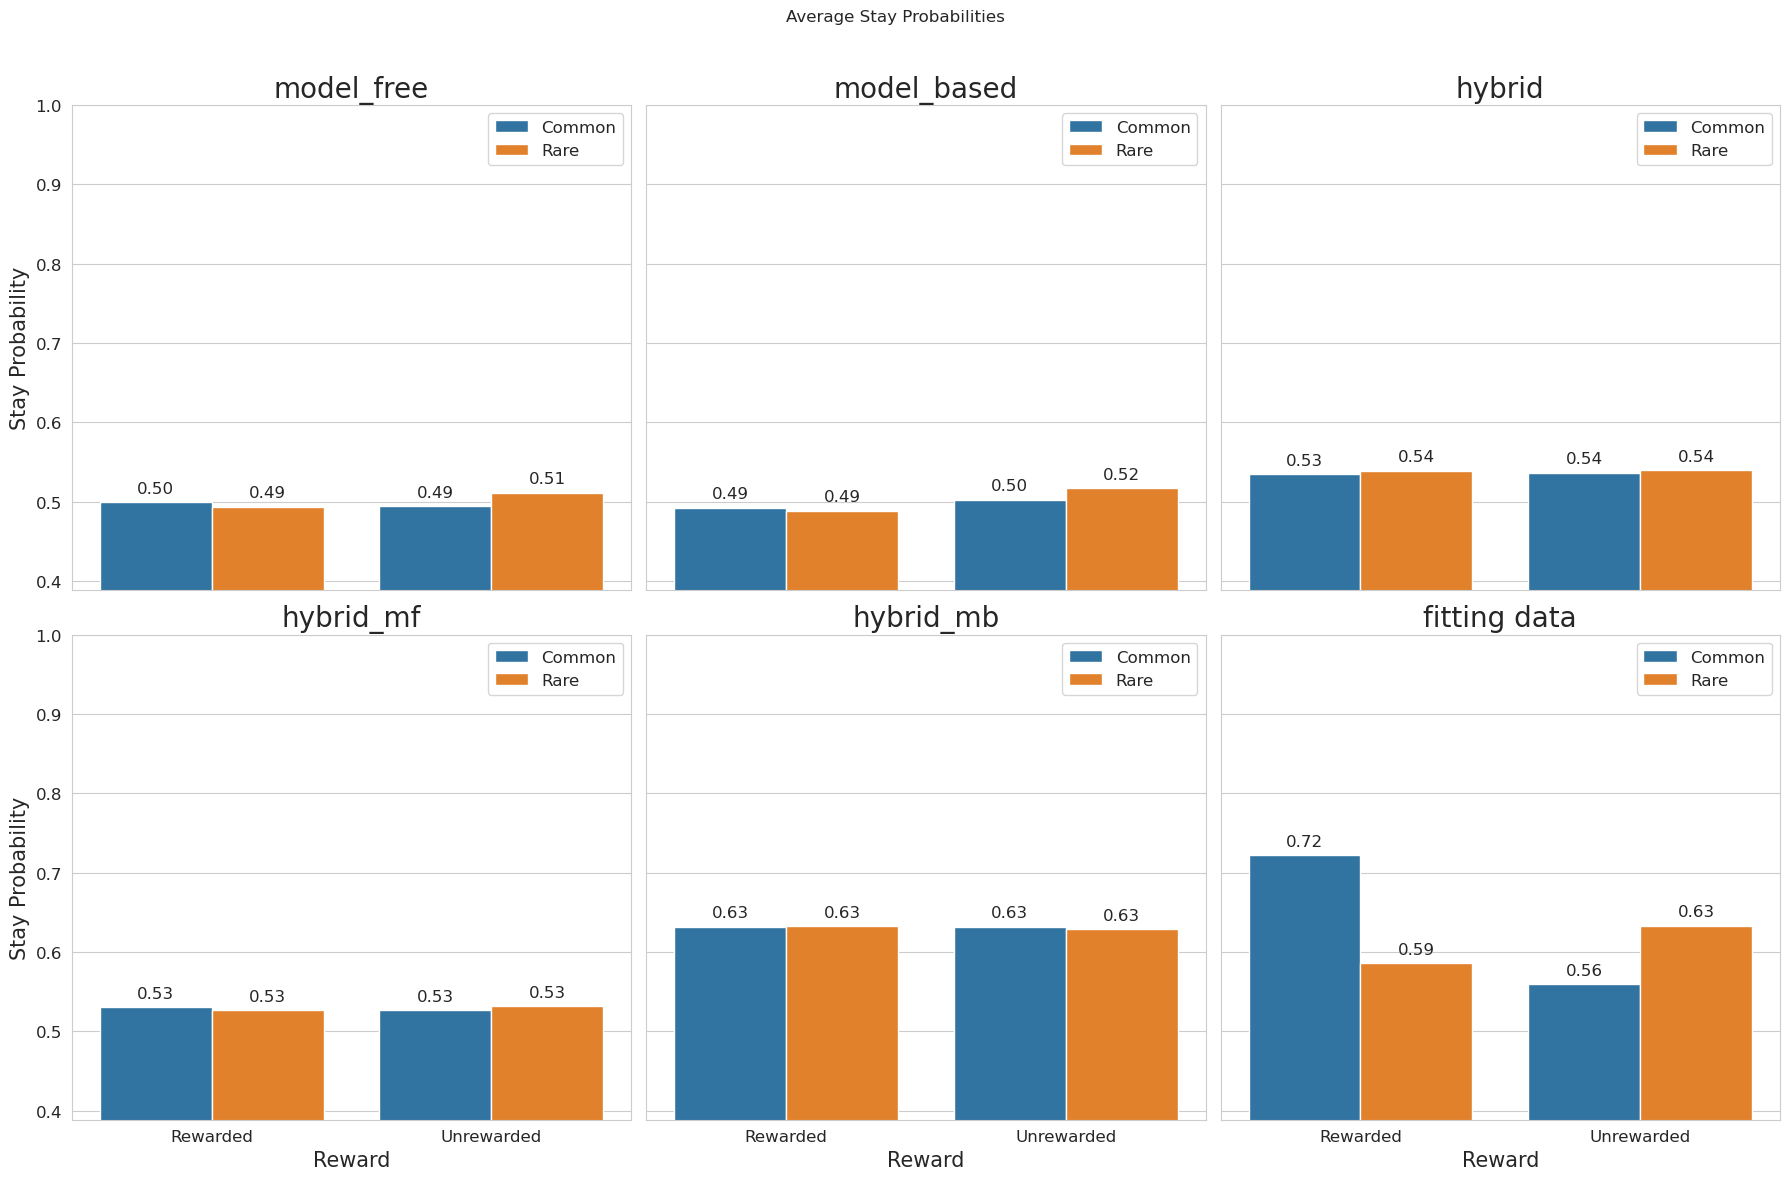

In [81]:
# take the average
all_data_mf = pd.concat(sampled_data_mf).reset_index(drop=True)
all_data_mb = pd.concat(sampled_data_mb).reset_index(drop=True)
all_data_hybrid = pd.concat(sampled_data_hybrid).reset_index(drop=True)
all_data_hybrid_mf = pd.concat(sampled_data_hybrid_mf).reset_index(drop=True)
all_data_hybrid_mb = pd.concat(sampled_data_hybrid_mb).reset_index(drop=True)
# Compute the average stay probabilities
average_data_mf = all_data_mf.groupby(['Rewarded', 'Common', 'Condition'])['Stay Probability'].mean().reset_index()
average_data_mb = all_data_mb.groupby(['Rewarded', 'Common', 'Condition'])['Stay Probability'].mean().reset_index()
average_data_hybrid = all_data_hybrid.groupby(['Rewarded', 'Common', 'Condition'])['Stay Probability'].mean().reset_index()
average_data_hybrid_mf = all_data_hybrid_mf.groupby(['Rewarded', 'Common', 'Condition'])['Stay Probability'].mean().reset_index()
average_data_hybrid_mb = all_data_hybrid_mb.groupby(['Rewarded', 'Common', 'Condition'])['Stay Probability'].mean().reset_index()
# display the average
# display('model_free', average_data_mf)
# display('model_based', average_data_mb)
# display('hybrid', average_data_hybrid)
# display('hybrid_mf', average_data_hybrid_mf)
# display('hybrid_mb', average_data_hybrid_mb)
# plot the average
data_stay_probabilities, _ = calculate_stay_probability(data) 
plot_stay_probabilities(dfs=[average_data_mf, average_data_mb, average_data_hybrid, average_data_hybrid_mf, average_data_hybrid_mb, data_stay_probabilities],
                        labels=['model_free', 'model_based', 'hybrid', 'hybrid_mf', 'hybrid_mb', 'fitting data'],
                        title='Average Stay Probabilities', max_plots_per_row=3)

/home/martin/Uni/semester_curr/Modeling_in_CogSci/rl-twoStepTask/utils.py:312: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/home/martin/Uni/semester_curr/Modeling_in_CogSci/rl-twoStepTask/utils.py:312: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/home/martin/Uni/semester_curr/Modeling_in_CogSci/rl-twoStepTask/utils.py:312: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/home/martin/Uni/semester_curr/Modeling_in_CogSci/rl-twoStepTask/utils.py:312: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax

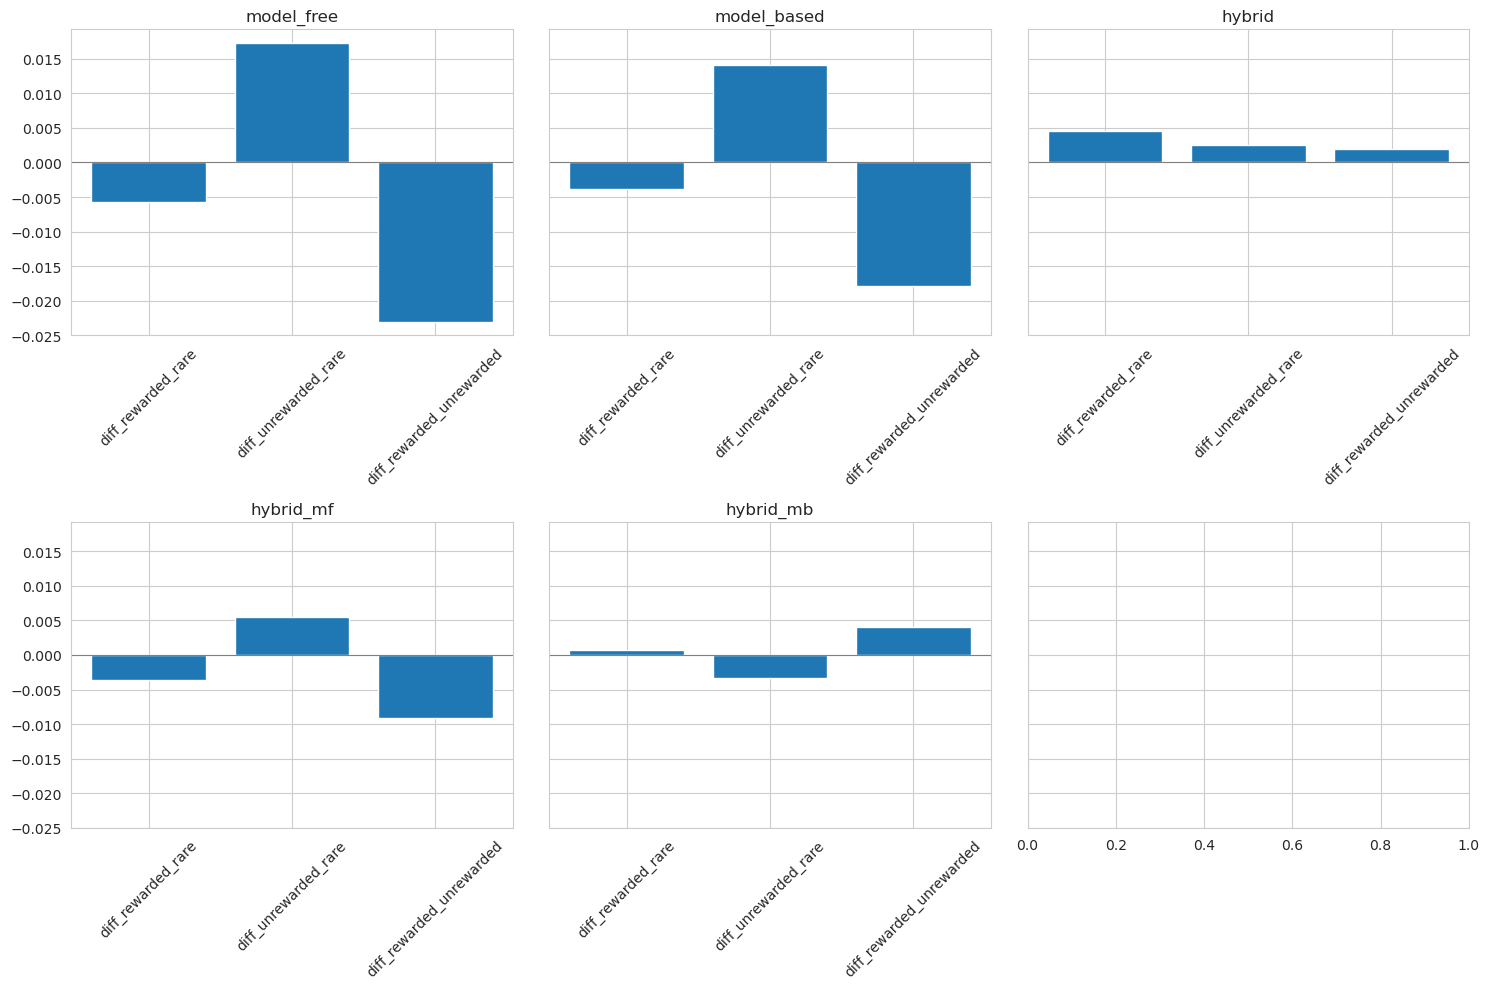

In [82]:
# first take the mean of the differences between rewarded common and rare transitions
# and unrewarded common and rare transitions
# then take the mean of the differences between the differences
sampled_data_lists = [sampled_data_mf, sampled_data_mb, sampled_data_hybrid, sampled_data_hybrid_mf, sampled_data_hybrid_mb]
model_titles = ['model_free', 'model_based', 'hybrid', 'hybrid_mf', 'hybrid_mb']
calculate_and_plot_diffs(sampled_data_lists, model_titles)

## Parameter Recovery *(5 points)*

For this exercise you should:

*   Set up a suitable space of parameters relevant for parameter recovery *(1 point)*

*   Use the functions above to generate behavior from a models, for a given set of (randomly sampled) parameters, and then fit the model to its generated data. Make sure to evaluate the parameter fit in a quantiative manner. *(3 points)*

*   Plot the parameter recovery results for both models. *(1 point)*

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [51]:
from parameter_recovery import param_recovery, plot_param_recovery, plot_param_correlation
import numpy as np
import pandas as pd
from scipy.stats import uniform

In [52]:
NUM_RUNS = 20
SEED = 0

NUM_ITERATIONS = 256  # Number of iterations for random search
NUM_INITILIZATIONS = 5  # Number of random initializations for minimize search
CONSIDER_BOTH_STAGES = True
kwargs_for_fitting_functions = {'num_iterations': NUM_ITERATIONS,
                                'num_initializations': NUM_INITILIZATIONS,
                                'consider_both_stages': CONSIDER_BOTH_STAGES}

INTERPOLATION_STEPS = 21 # Number of steps for interpolation of the parameter space
# define the parameter space for the simple model free and based
ALPHA_RANGE = (0.01, 0.8)
BETA_RANGE = (-4, 8)
# Define parameter distributions for hybrid model and its tow special cases (model free and model based)
ALPHA_1_RANGE = (0.01, 0.8)
ALPHA_2_RANGE = (0.01, 0.8)
BETA_1_RANGE = (-4, 8)
BETA_2_RANGE = (-4, 8)
LAMBDA_RANGE = (0, 1)
W_RANGE = (0, 1)
P_RANGE = (-2, 2)

param_space = {'alpha': np.linspace(*ALPHA_RANGE, INTERPOLATION_STEPS),
                'beta': np.linspace(*BETA_RANGE, INTERPOLATION_STEPS)}
param_distributions = {'alpha': uniform(ALPHA_RANGE[0], ALPHA_RANGE[1] - ALPHA_RANGE[0]),
                        'beta': uniform(BETA_RANGE[0], BETA_RANGE[1] - BETA_RANGE[0])}

param_space_hybrid = {
    'alpha_1': np.linspace(*ALPHA_1_RANGE, INTERPOLATION_STEPS),
    'alpha_2': np.linspace(*ALPHA_2_RANGE, INTERPOLATION_STEPS),
    'beta_1': np.linspace(*BETA_1_RANGE, INTERPOLATION_STEPS),
    'beta_2': np.linspace(*BETA_2_RANGE, INTERPOLATION_STEPS),
    '_lambda': np.linspace(*LAMBDA_RANGE, INTERPOLATION_STEPS),
    'w': np.linspace(*W_RANGE, INTERPOLATION_STEPS),
    'p': np.linspace(*P_RANGE, INTERPOLATION_STEPS),
}
# TODO fix the uniform distribution range, it is ( loc , scale + loc )
param_distributions_hybrid = {
    'alpha_1': uniform(ALPHA_1_RANGE[0], ALPHA_1_RANGE[1] - ALPHA_1_RANGE[0]),
    'alpha_2': uniform(ALPHA_2_RANGE[0], ALPHA_2_RANGE[1] - ALPHA_2_RANGE[0]),
    'beta_1': uniform(BETA_1_RANGE[0], BETA_1_RANGE[1] - BETA_1_RANGE[0]),
    'beta_2': uniform(BETA_2_RANGE[0], BETA_2_RANGE[1] - BETA_2_RANGE[0]),
    '_lambda': uniform(LAMBDA_RANGE[0], LAMBDA_RANGE[1] - LAMBDA_RANGE[0]),
    'w': uniform(W_RANGE[0], W_RANGE[1] - W_RANGE[0]),
    'p': uniform(P_RANGE[0], P_RANGE[1] - P_RANGE[0])
}

In [53]:
# parameter recovery for the model free agent
fitted_params_mf, true_params_mf, best_ll_mf_list = param_recovery(agent_type='model_free',
                                                        parameter_space=param_space,
                                                        fit_type='minimize_search',
                                                        num_runs=NUM_RUNS,
                                                        seed=SEED,
                                                        **kwargs_for_fitting_functions)

# fitted_params_mf, true_params_mf, best_ll_mf_list = param_recovery(agent_type='model_free',
#                                                         parameter_space=param_space,
#                                                         fit_type='grid_search',
#                                                         num_runs=NUM_RUNS,
#                                                         seed=SEED,
#                                                         **kwargs_for_fitting_functions)

fitting_runs::   0%|          | 0/20 [00:00<?, ?it/s]

fitting_runs:: 100%|██████████| 20/20 [04:41<00:00, 14.07s/it]


In [54]:
# parameter recovery for the model based agent
fitted_params_mb, true_params_mb, best_ll_mb_list = param_recovery(agent_type='model_based',
                                                        parameter_space=param_space,
                                                        fit_type='minimize_search',
                                                        num_runs=NUM_RUNS,
                                                        seed=SEED,
                                                        **kwargs_for_fitting_functions)

# fitted_params_mb, true_params_mb, best_ll_mb_list = param_recovery(agent_type='model_based',
#                                                         parameter_space=param_space,
#                                                         fit_type='grid_search',
#                                                         num_runs=NUM_RUNS,
#                                                         seed=SEED)

fitting_runs:: 100%|██████████| 20/20 [04:05<00:00, 12.29s/it]


In [55]:
# parameter recovery for the hybrid agent 
fitted_params_hybrid, true_params_hybrid, best_ll_hybrid_list = param_recovery(agent_type='hybrid',
                                                        parameter_space=param_space_hybrid,
                                                        fit_type='minimize_search',
                                                        num_runs=NUM_RUNS,
                                                        seed=SEED,
                                                        **kwargs_for_fitting_functions)

# fitted_params_hybrid, true_params_hybrid, best_ll_hybrid_list = param_recovery(agent_type='hybrid',
#                                                         parameter_space=param_distributions_hybrid,
#                                                         fit_type='random_search',
#                                                         num_runs=NUM_RUNS,
#                                                         seed=SEED,
#                                                         **kwargs_for_fitting_functions)


fitting_runs::  35%|███▌      | 7/20 [08:02<15:23, 71.06s/it]/home/martin/Uni/semester_curr/Modeling_in_CogSci/rl-twoStepTask/parameter_fitting.py:71: RuntimeWarning: divide by zero encountered in log
  LogLikelihood_sum += np.log(chosen_action_1_prob)
/home/martin/miniconda3/envs/m_cs/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
fitting_runs::  65%|██████▌   | 13/20 [15:07<08:30, 72.87s/it]/home/martin/Uni/semester_curr/Modeling_in_CogSci/rl-twoStepTask/parameter_fitting.py:71: RuntimeWarning: divide by zero encountered in log
  LogLikelihood_sum += np.log(chosen_action_1_prob)
/home/martin/miniconda3/envs/m_cs/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
fitting_runs::  75%|███████▌  | 15/20 [17:13<05:37, 67.57s/it]/home/martin/Uni/semester_curr/Modeling_in_CogSci/rl-twoStepTask/parameter_fitting.py:71: Runti

In [56]:
# parameter recovery for the model free as special case of hybrid agent
param_space_hybrid_mf = param_space_hybrid.copy()
param_space_hybrid_mf['w'] = np.array([0.0])
fitted_params_hybrid_mf, true_params_hybrid_mf, best_ll_hybrid_mf_list = param_recovery(agent_type='hybrid',
                                                        parameter_space=param_space_hybrid_mf,
                                                        fit_type='minimize_search',
                                                        num_runs=NUM_RUNS,
                                                        seed=SEED,
                                                        **kwargs_for_fitting_functions) 

fitting_runs::  10%|█         | 2/20 [01:50<16:48, 56.02s/it]/home/martin/Uni/semester_curr/Modeling_in_CogSci/rl-twoStepTask/parameter_fitting.py:71: RuntimeWarning: divide by zero encountered in log
  LogLikelihood_sum += np.log(chosen_action_1_prob)
/home/martin/miniconda3/envs/m_cs/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
fitting_runs::  15%|█▌        | 3/20 [02:55<16:56, 59.78s/it]/home/martin/Uni/semester_curr/Modeling_in_CogSci/rl-twoStepTask/parameter_fitting.py:71: RuntimeWarning: divide by zero encountered in log
  LogLikelihood_sum += np.log(chosen_action_1_prob)
/home/martin/miniconda3/envs/m_cs/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
fitting_runs::  20%|██        | 4/20 [03:59<16:25, 61.62s/it]/home/martin/Uni/semester_curr/Modeling_in_CogSci/rl-twoStepTask/parameter_fitting.py:71: Runtime

In [57]:
# parameter recovery for the model based as special case of hybrid agent
param_space_hybrid_mb = param_space_hybrid.copy()
param_space_hybrid_mb['w'] = np.array([1.0])
fitted_params_hybrid_mb, true_params_hybrid_mb, best_ll_hybrid_mb_list = param_recovery(agent_type='hybrid',
                                                        parameter_space=param_space_hybrid_mb,
                                                        fit_type='minimize_search',
                                                        num_runs=NUM_RUNS,
                                                        seed=SEED,
                                                        **kwargs_for_fitting_functions)

fitting_runs:: 100%|██████████| 20/20 [20:45<00:00, 62.28s/it]


Pearson correlation for alpha: 0.748, p_value: 0.0001472284954367007
Pearson correlation for beta: 0.744, p_value: 0.0001686230245252904


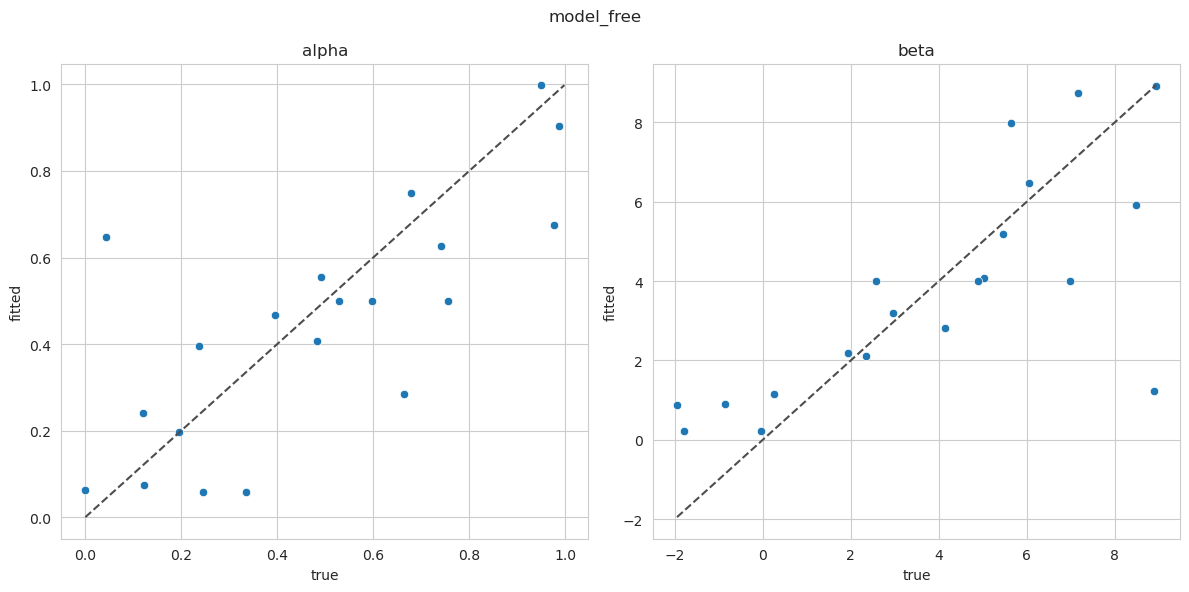

Pearson correlation for alpha: 0.910, p_value: 2.6808557810131345e-08
Pearson correlation for beta: 0.975, p_value: 2.835923207321288e-13


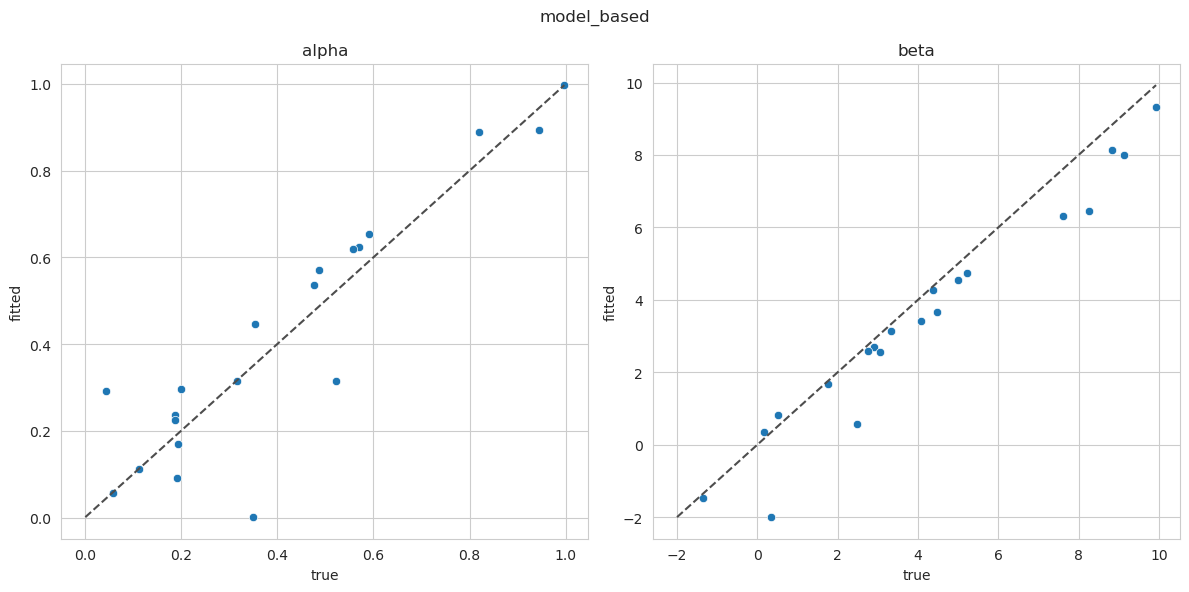

Pearson correlation for alpha_1: 0.138, p_value: 0.5624104633533775
Pearson correlation for alpha_2: 0.357, p_value: 0.12238051627026852
Pearson correlation for beta_1: 0.660, p_value: 0.001535540702216858
Pearson correlation for beta_2: -0.015, p_value: 0.948301497459515
Pearson correlation for _lambda: 0.112, p_value: 0.6392237190928596
Pearson correlation for w: 0.088, p_value: 0.7125441667541301
Pearson correlation for p: 0.259, p_value: 0.27044838933428406


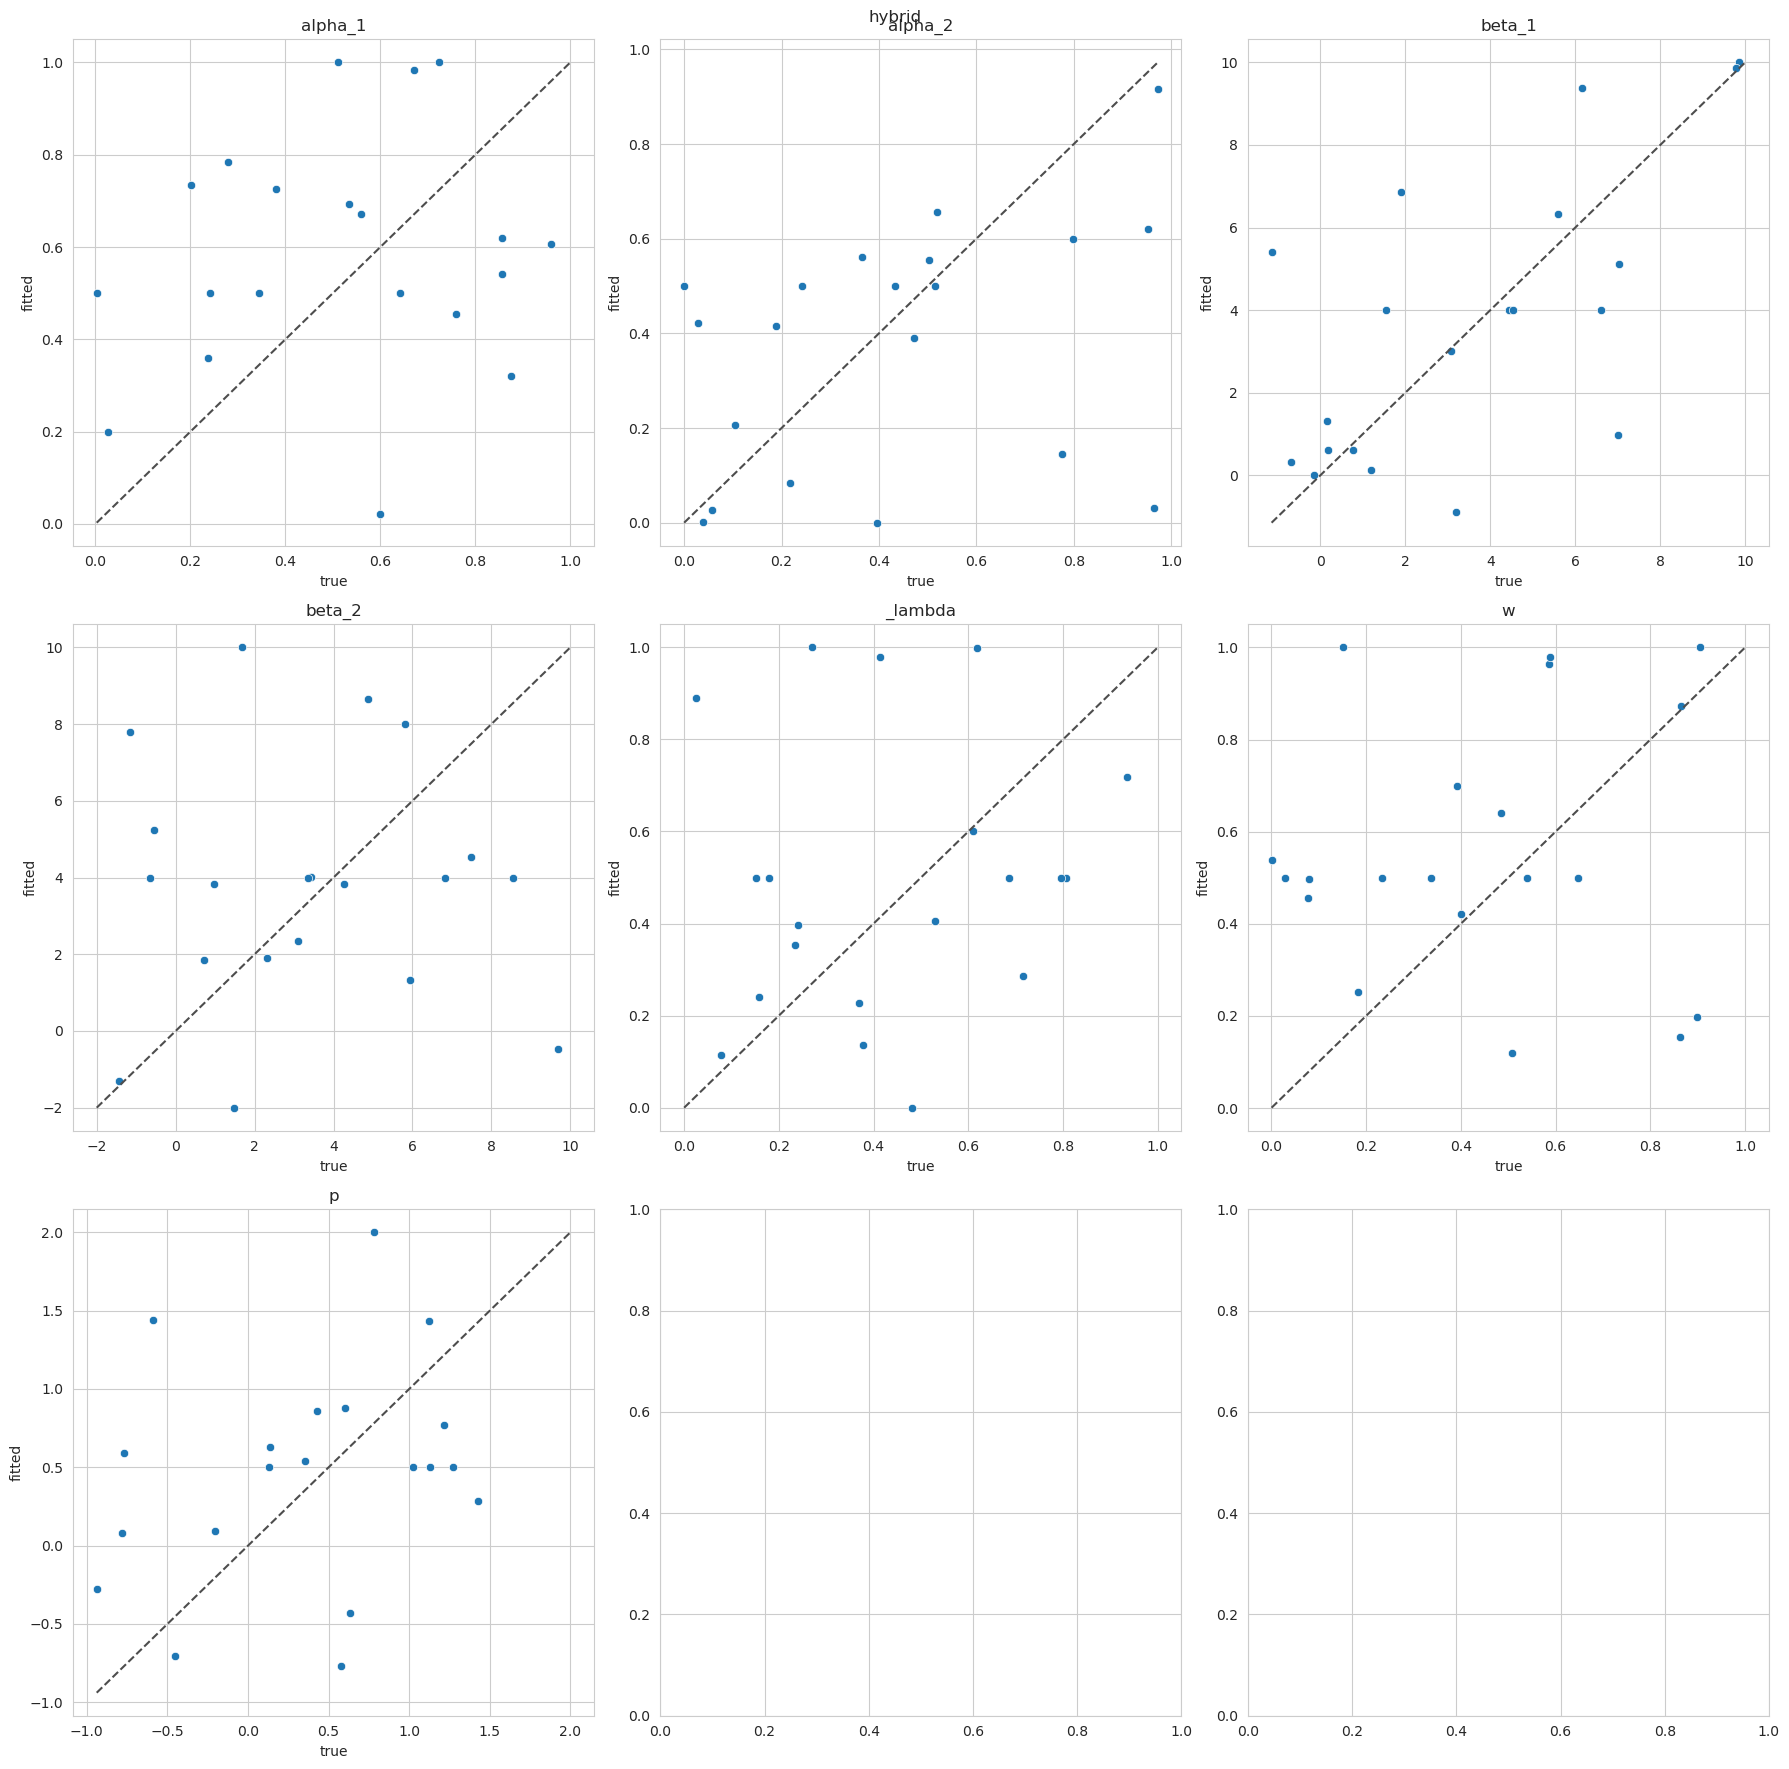

Pearson correlation for alpha_1: 0.093, p_value: 0.6957392603004904
Pearson correlation for alpha_2: 0.126, p_value: 0.5980017646128879
Pearson correlation for beta_1: 0.351, p_value: 0.1296563257646315
Pearson correlation for beta_2: 0.262, p_value: 0.26524148590271984
Pearson correlation for _lambda: 0.017, p_value: 0.9439951581175616
Pearson correlation for w: nan, p_value: nan
Pearson correlation for p: 0.697, p_value: 0.0006380160020752405


/home/martin/miniconda3/envs/m_cs/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


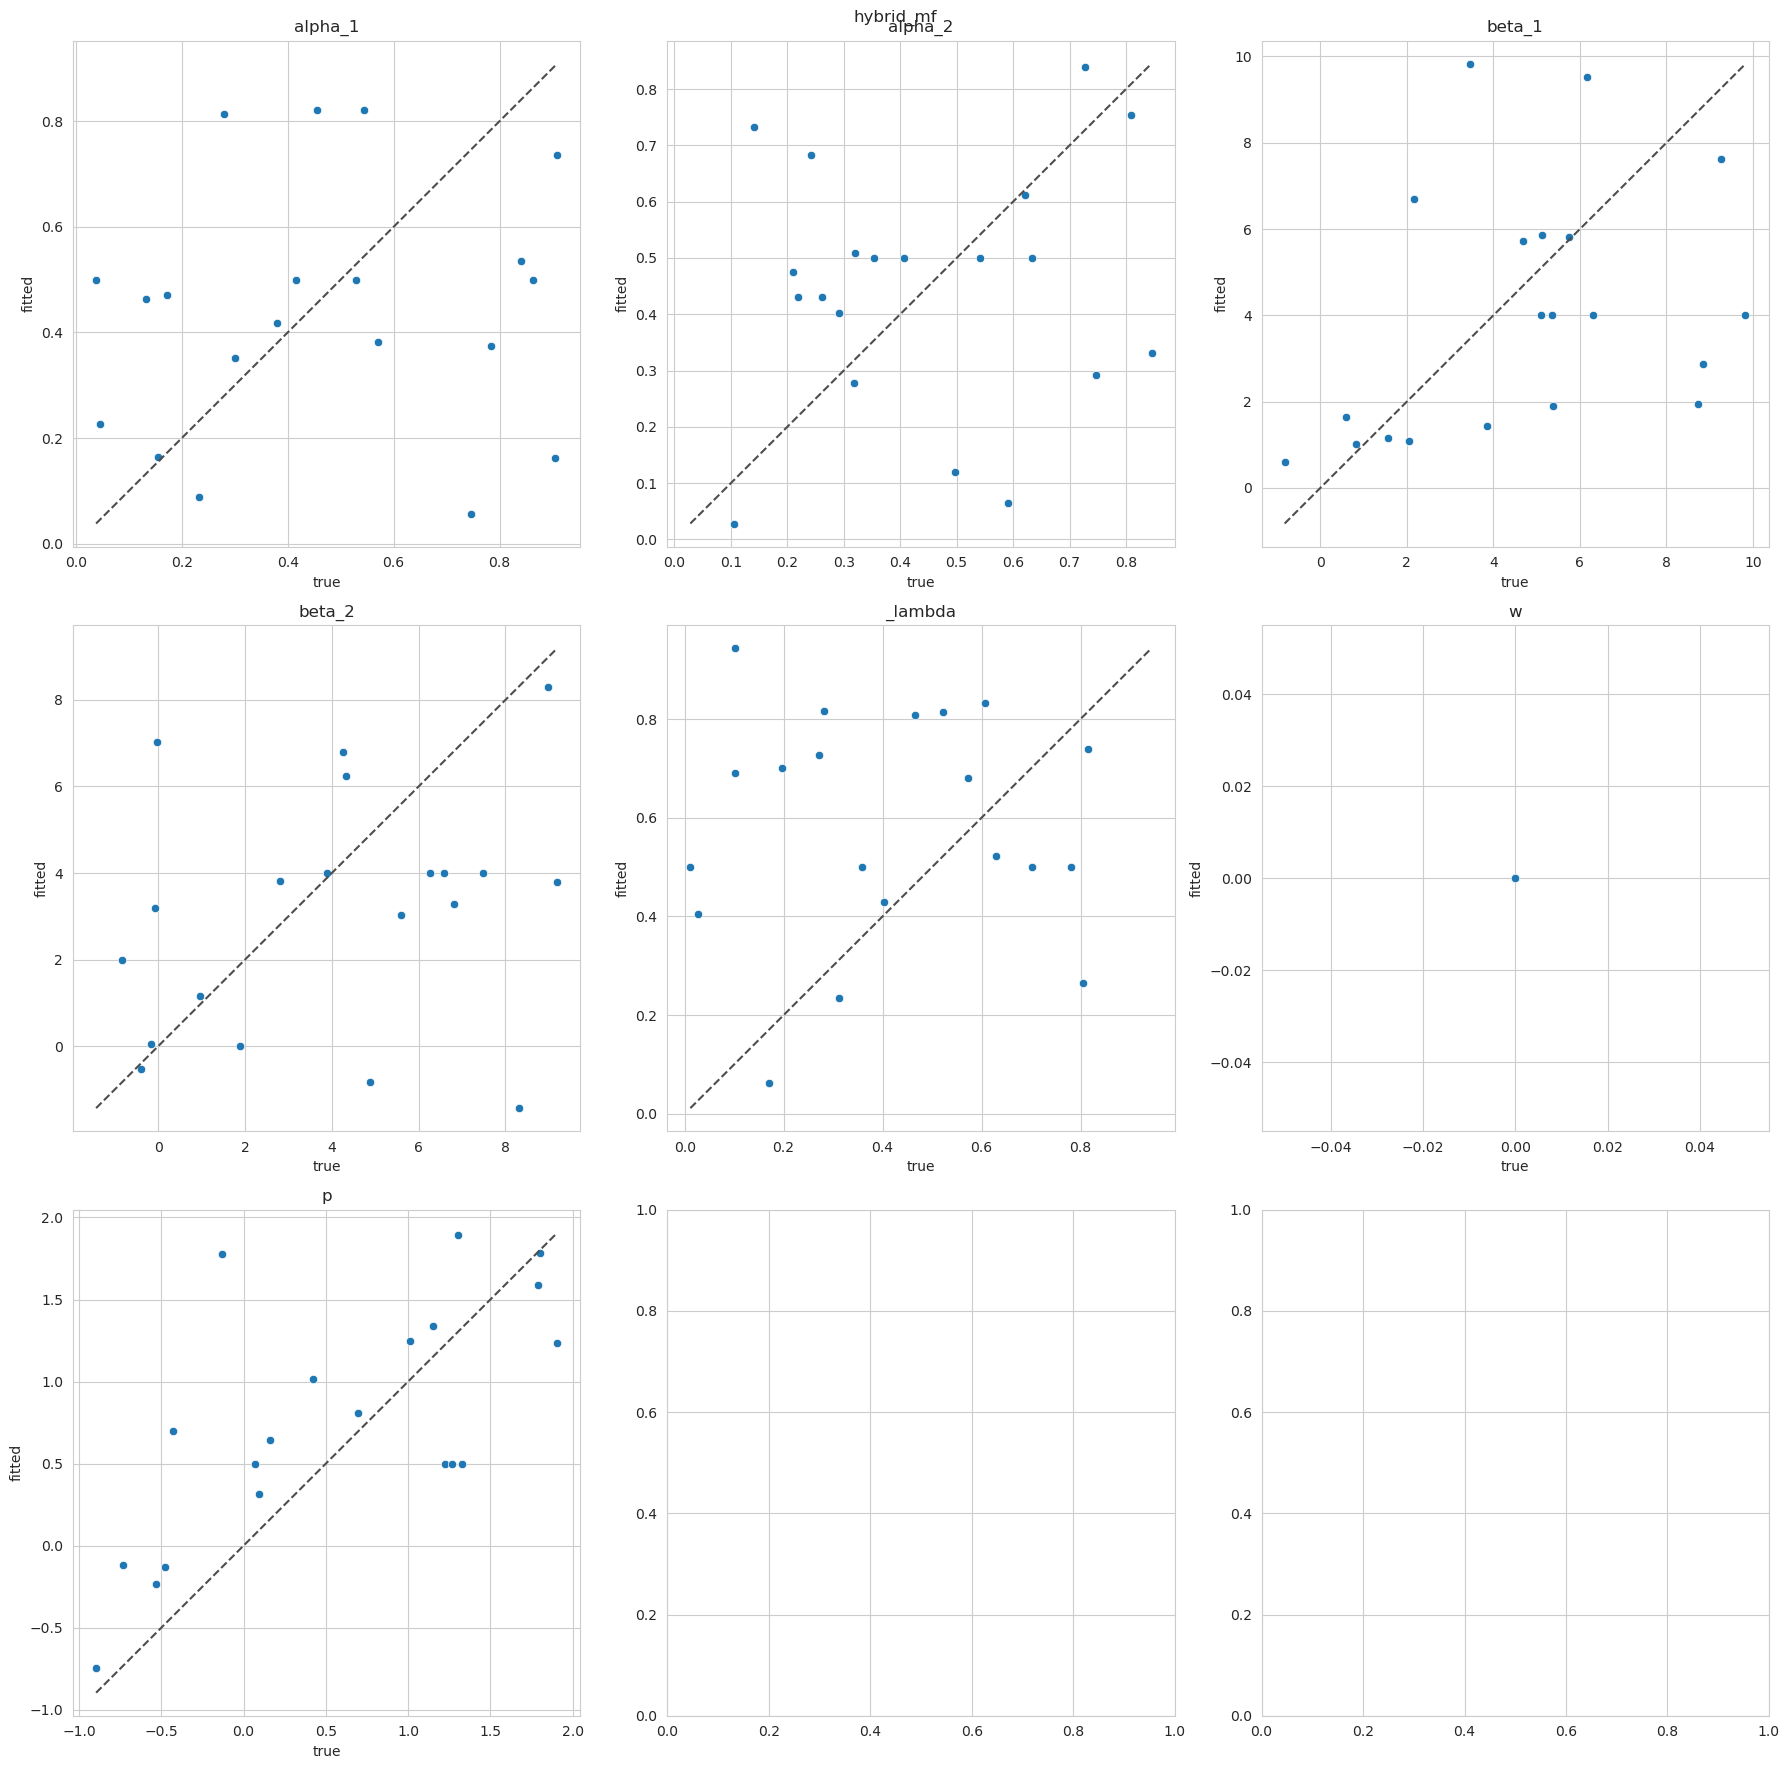

Pearson correlation for alpha_1: 0.038, p_value: 0.8740397579808172
Pearson correlation for alpha_2: 0.970, p_value: 1.8165609825895122e-12
Pearson correlation for beta_1: 0.845, p_value: 2.6988530735382666e-06
Pearson correlation for beta_2: 0.971, p_value: 1.1402548570404103e-12
Pearson correlation for _lambda: 0.084, p_value: 0.7251695028394554
Pearson correlation for w: nan, p_value: nan
Pearson correlation for p: 0.944, p_value: 4.0157861435467826e-10


/home/martin/miniconda3/envs/m_cs/lib/python3.11/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


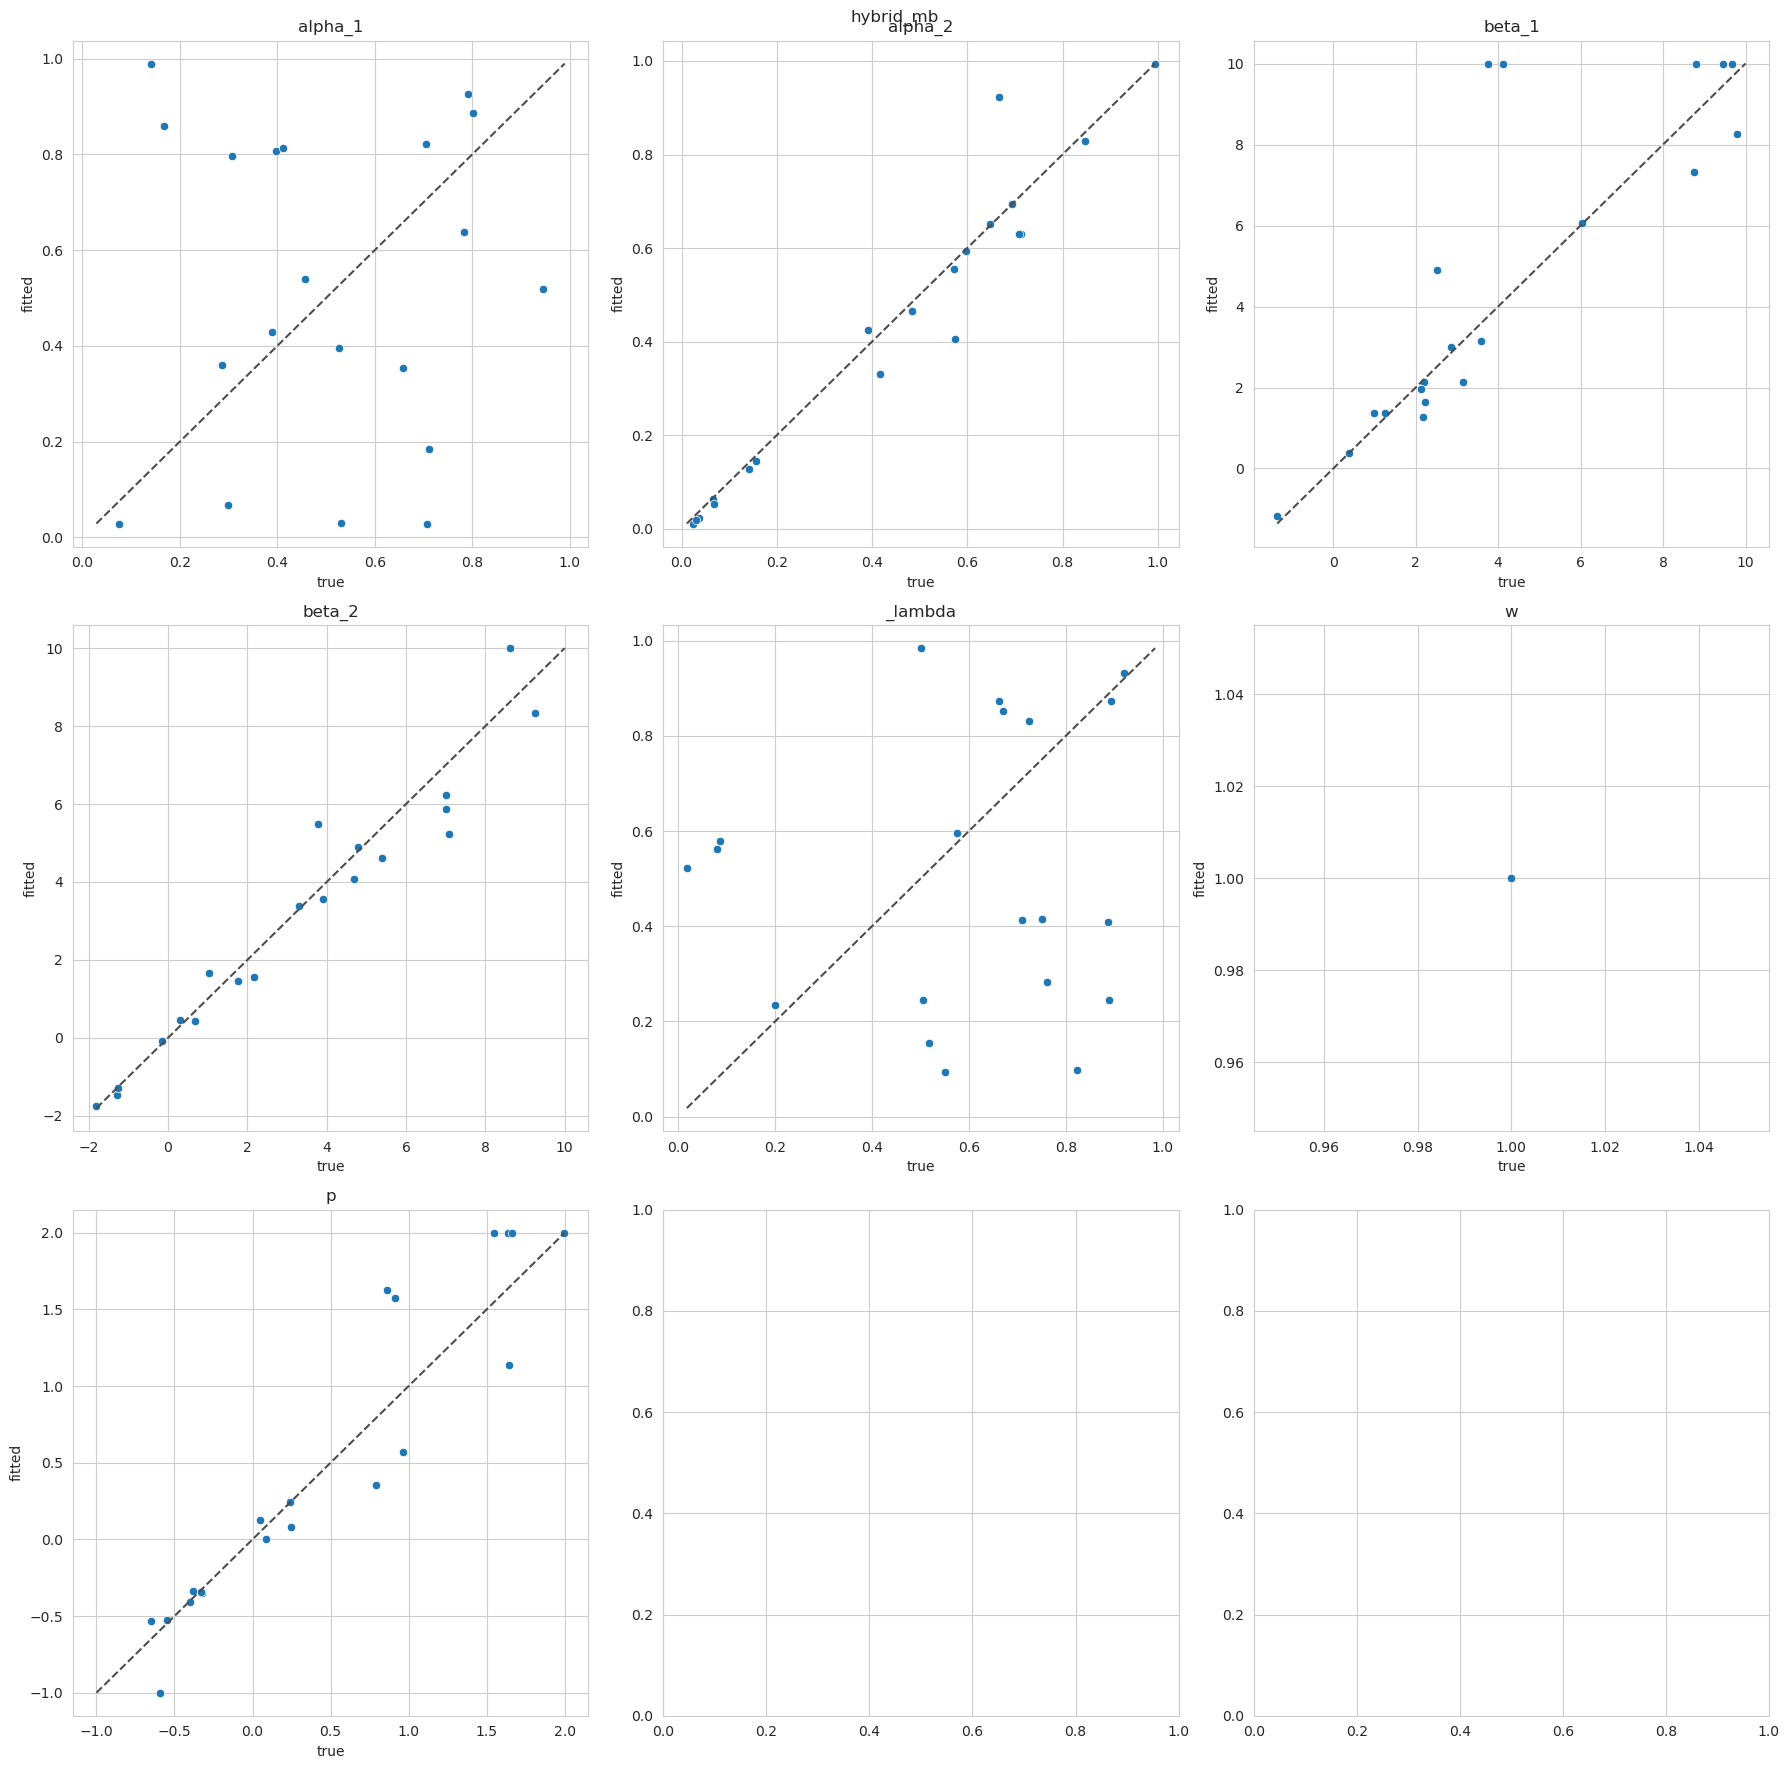

In [60]:
# plot the results
plot_param_recovery(true_params_mf, fitted_params_mf, 'model_free')
plot_param_recovery(true_params_mb, fitted_params_mb, 'model_based')
plot_param_recovery(true_params_hybrid, fitted_params_hybrid, 'hybrid')
plot_param_recovery(true_params_hybrid_mf, fitted_params_hybrid_mf, 'hybrid_mf')
plot_param_recovery(true_params_hybrid_mb, fitted_params_hybrid_mb, 'hybrid_mb')

corr_1: PearsonRResult(statistic=0.15588456920391056, pvalue=0.5116443955481144)


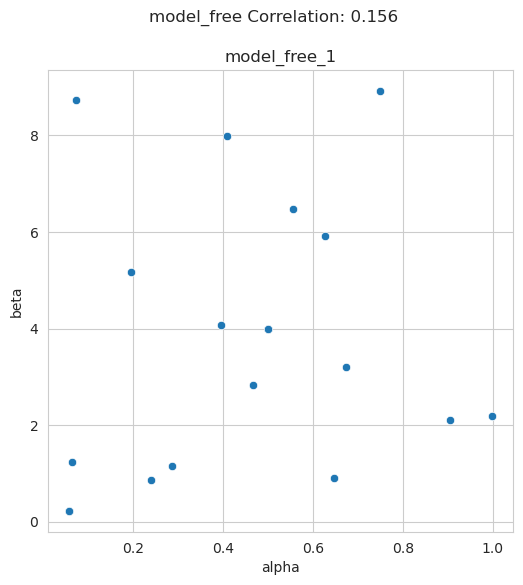

corr_1: PearsonRResult(statistic=0.1592828402273757, pvalue=0.5023667740018745)


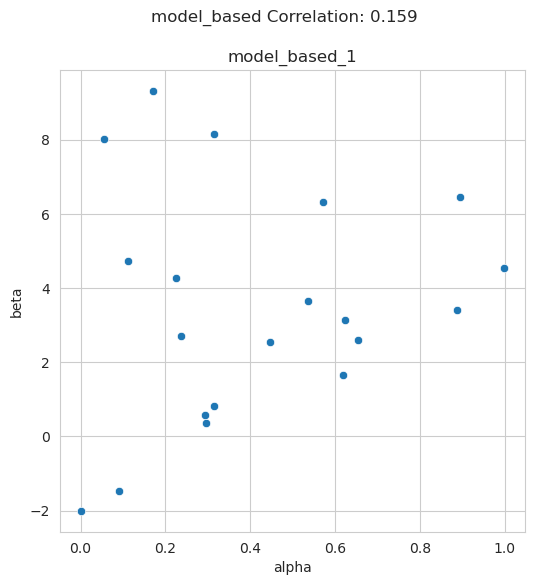

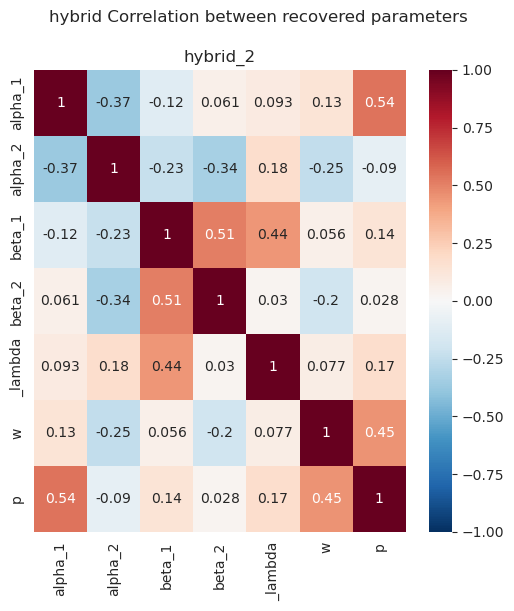

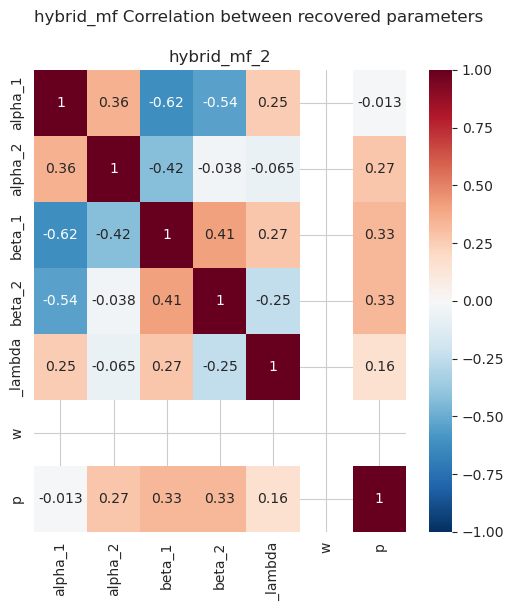

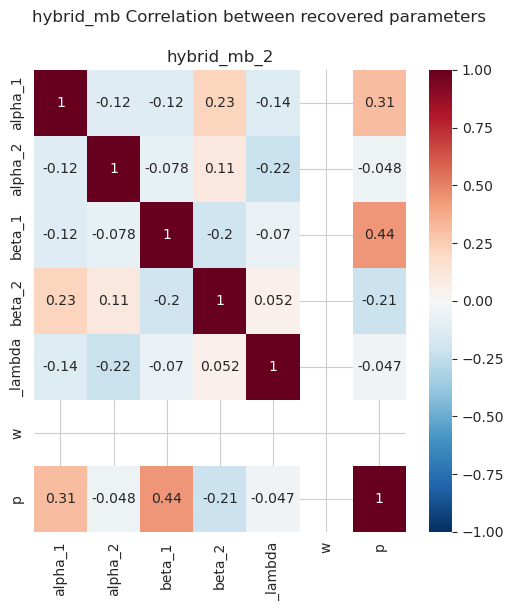

In [72]:
# plot recovered parameters correlation
# low is good
plot_param_correlation(fitted_params_mf, 'model_free')
plot_param_correlation(fitted_params_mb, 'model_based')
plot_param_correlation(fitted_params_hybrid, 'hybrid')
plot_param_correlation(fitted_params_hybrid_mf, 'hybrid_mf')
plot_param_correlation(fitted_params_hybrid_mb, 'hybrid_mb')

## *Optional*: Model Recovery *(2 bonus points)*

In this bonus exercise, you may examine model reovery. The bonus points count towards your total group project points. That is, you may accumlate up to 22 points in the practical part of the group project.

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [1]:
from model_recovery import model_recovery, plot_confusion_matrix
from scipy.stats import uniform

In [2]:
NUM_RUNS = 20
SEED = 1

# NUM_ITERATIONS = 256  # Number of iterations for random search
NUM_INITILIZATIONS = 1 # Number of random initializations for minimize search
CONSIDER_BOTH_STAGES = True
kwargs_for_fitting_functions = {'num_initializations': NUM_INITILIZATIONS,
                                'consider_both_stages': CONSIDER_BOTH_STAGES}

INTERPOLATION_STEPS = 21 # Number of steps for interpolation of the parameter space
# define the parameter space for the simple model free and based
ALPHA_RANGE = (0.05, 0.85)
BETA_RANGE = (-4, 8)
# Define parameter distributions for hybrid model and its tow special cases (model free and model based)
ALPHA_1_RANGE = (0.05, 0.85)
ALPHA_2_RANGE = (0.05, 0.85)
BETA_1_RANGE = (-4, 8)
BETA_2_RANGE = (-4, 8)
LAMBDA_RANGE = (0.2, 0.8)
W_RANGE = (0.2, 0.8)
P_RANGE = (-1, 1)

# uniform (loc, scale) => uniform (loc, loc + scale)
param_distributions_simple = {'alpha': uniform(ALPHA_RANGE[0], ALPHA_RANGE[1] - ALPHA_RANGE[0]),
                        'beta': uniform(BETA_RANGE[0], BETA_RANGE[1] - BETA_RANGE[0])}

param_distributions_hybrid = {
    'alpha_1': uniform(ALPHA_1_RANGE[0], ALPHA_1_RANGE[1] - ALPHA_1_RANGE[0]),
    'alpha_2': uniform(ALPHA_2_RANGE[0], ALPHA_2_RANGE[1] - ALPHA_2_RANGE[0]),
    'beta_1': uniform(BETA_1_RANGE[0], BETA_1_RANGE[1] - BETA_1_RANGE[0]),
    'beta_2': uniform(BETA_2_RANGE[0], BETA_2_RANGE[1] - BETA_2_RANGE[0]),
    '_lambda': uniform(LAMBDA_RANGE[0], LAMBDA_RANGE[1] - LAMBDA_RANGE[0]),
    'w': uniform(W_RANGE[0], W_RANGE[1] - W_RANGE[0]),
    'p': uniform(P_RANGE[0], P_RANGE[1] - P_RANGE[0]),
}
param_distributions_hybrid_mf = param_distributions_hybrid.copy()
param_distributions_hybrid_mf['w'] = uniform(0, 0)
param_distributions_hybrid_mb = param_distributions_hybrid.copy()
param_distributions_hybrid_mb['w'] = uniform(1, 0)

In [3]:
models_priors = {
                'model_free': param_distributions_simple,
                 'model_based': param_distributions_simple,
                 'hybrid': param_distributions_hybrid,
                 'hybrid_mf': param_distributions_hybrid_mf,
                 'hybrid_mb': param_distributions_hybrid_mb
                }

In [4]:
conf_matrix_df, inversion_matrix_df = model_recovery(models_priors, num_simulations=NUM_RUNS, seed=SEED, 
                                                     fit_func_kwargs={'num_initializations': NUM_INITILIZATIONS})

models::   0%|          | 0/5 [00:00<?, ?it/s]

simulating model recovery for: model_free:   0%|          | 0/20 [00:00<?, ?it/s]

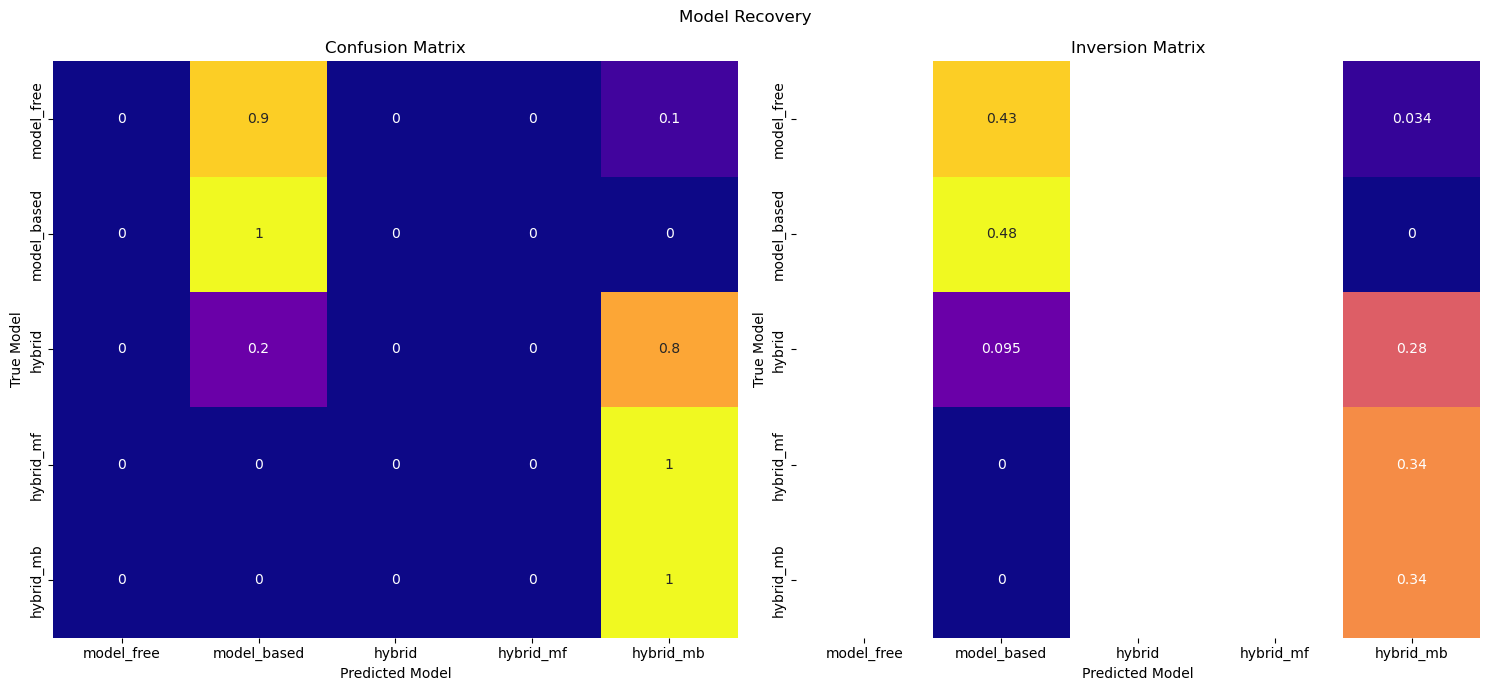

In [ ]:
plot_confusion_matrix(conf_matrix_df, inversion_matrix_df,
                      title=f'Model Recovery, {NUM_RUNS} simulations.')

In [ ]:
NUM_RUNS = 20
SEED = 1

# NUM_ITERATIONS = 256  # Number of iterations for random search
NUM_INITILIZATIONS = 3 # Number of random initializations for minimize search
CONSIDER_BOTH_STAGES = True
kwargs_for_fitting_functions = {'num_initializations': NUM_INITILIZATIONS,
                                'consider_both_stages': CONSIDER_BOTH_STAGES}

models_priors_hybirds = {
                 'hybrid': param_distributions_hybrid,
                 'hybrid_mf': param_distributions_hybrid_mf,
                 'hybrid_mb': param_distributions_hybrid_mb
                }

In [ ]:
conf_matrix_df_hybirds, inversion_matrix_df_hybirds = model_recovery(models_priors_hybirds, num_simulations=NUM_RUNS, seed=SEED, 
                                                     fit_func_kwargs={'num_initializations': NUM_INITILIZATIONS})

models::   0%|          | 0/3 [00:00<?, ?it/s]

Running model recovery for hybrid


Simulating hybrid agent, 200 trials.
Agent parameters: {'alpha_1': 0.4435626681025866, 'alpha_2': 0.5749995994342114, 'beta_1': 3.233160512859726, 'beta_2': 2.538598195962763, '_lambda': 0.4236547993389047, 'w': 0.6458941130666561, 'p': -0.24965115494922996}


Simulating hybrid agent, 200 trials.
Agent parameters: {'alpha_1': 0.4628693061126287, 'alpha_2': 0.6625835944086096, 'beta_1': 0.4404717530656015, 'beta_2': 7.652665280766422, '_lambda': 0.7215184409492578, 'w': 0.7923581649336835, 'p': 1.790004583596621}


Simulating hybrid agent, 200 trials.
Agent parameters: {'alpha_1': 0.6298568965873736, 'alpha_2': 0.32394886926649863, 'beta_1': 5.36951305001058, 'beta_2': 6.70348215944882, '_lambda': 0.674872340567202, 'w': 0.2523131314646698, 'p': 0.2879695034388954}


Simulating hybrid agent, 200 trials.
Agent parameters: {'alpha_1': 0.4613785811189903, 'alpha_2': 0.20107802444858847, 'beta_1': 5.448786039300915, 'beta_2': -2.7980572124384033, '_lambda': 0.4470161310119989, 'w': 0.5454806686027166, 'p': 0.09585435704289269}


Simulating hybrid agent, 200 trials.
Agent parameters: {'alpha_1': 0.7933577510201922, 'alpha_2': 0.34306827664712, 'beta_1': 4.235410976259237, 'beta_2': -3.9829647683955574, '_lambda': 0.5215062753486363, 'w': 0.9498420672986464, 'p': 0.23060155772791235}


Simulating hybrid agent, 200 trials.
Agent parameters: {'alpha_1': 0.5115198636370932, 'alpha_2': 0.4552421346396385, 'beta_1': -0.10340870721727002, 'beta_2': 1.1804847916777481, '_lambda': 0.42934110807223136, 'w': 0.8597046935339043, 'p': -1.687680294245487}


Simulating hybrid agent, 200 trials.
Agent parameters: {'alpha_1': 0.7694889730558004, 'alpha_2': 0.6666346988604411, 'beta_1': 1.4845164237930089, 'beta_2': 5.944867426926585, '_lambda': 0.7081942586746808, 'w': 0.7654092358341885, 'p': 1.2934057040213731}


Simulating hybrid agent, 200 trials.
Agent parameters: {'alpha_1': 0.43143191046012375, 'alpha_2': 0.1570590005882661, 'beta_1': -3.889975248823561, 'beta_2': 2.8567812885029955, '_lambda': 0.06990454423195802, 'w': 0.1364266038753762, 'p': -0.1576744780078001}


Simulating hybrid agent, 200 trials.
Agent parameters: {'alpha_1': 0.3482999078279309, 'alpha_2': 0.60564493070104, 'beta_1': -1.119662096936862, 'beta_2': 3.7473888400632447, '_lambda': 0.5331825813975338, 'w': 0.9154918588515557, 'p': 0.4056774928395317}


Simulating hybrid agent, 200 trials.
Agent parameters: {'alpha_1': 0.23778430848424817, 'alpha_2': 0.5583542060951803, 'beta_1': 7.177123591798139, 'beta_2': -0.36599510991718853, '_lambda': 0.06282897120319608, 'w': 0.3303572789535244, 'p': 1.041195986751271}


models::  33%|███▎      | 1/3 [04:26<08:53, 266.58s/it]

Running model recovery for hybrid_mf


Simulating hybrid_mf agent, 200 trials.
Agent parameters: {'alpha_1': 0.6579247230773425, 'alpha_2': 0.2611813167628715, 'beta_1': -3.2536592015691506, 'beta_2': -1.576040437794572, '_lambda': 0.141076181917277, 'w': 0.0, 'p': 1.1052235140753708}


Simulating hybrid_mf agent, 200 trials.
Agent parameters: {'alpha_1': 0.3616883891437304, 'alpha_2': 0.7273993062207869, 'beta_1': -0.5558807726625448, 'beta_2': 2.858359431891053, '_lambda': 0.42072630035229686, 'w': 0.0, 'p': -0.39859140576437957}


Simulating hybrid_mf agent, 200 trials.
Agent parameters: {'alpha_1': 0.28835003188933833, 'alpha_2': 0.3384848465971845, 'beta_1': -2.964857310353693, 'beta_2': 6.726301009332154, '_lambda': 0.914339856999609, 'w': 0.0, 'p': 0.3946268701652951}


Simulating hybrid_mf agent, 200 trials.
Agent parameters: {'alpha_1': 0.3286087832689682, 'alpha_2': 0.012744522838875404, 'beta_1': 4.948816946807192, 'beta_2': -3.3181029141935516, '_lambda': 0.8375073741876135, 'w': 0.0, 'p': 0.7943249337758931}


Simulating hybrid_mf agent, 200 trials.
Agent parameters: {'alpha_1': 0.23328525765099378, 'alpha_2': 0.7717736987306231, 'beta_1': -3.5261729035630847, 'beta_2': 2.1968343196891356, '_lambda': 0.8542224472606592, 'w': 0.0, 'p': -1.4878216291248587}


Simulating hybrid_mf agent, 200 trials.
Agent parameters: {'alpha_1': 0.010952200532706442, 'alpha_2': 0.2888937327271539, 'beta_1': -1.1802822620731575, 'beta_2': -3.836010206929409, '_lambda': 0.5953595490566911, 'w': 0.0, 'p': 1.3871593695280238}


Simulating hybrid_mf agent, 200 trials.
Agent parameters: {'alpha_1': 0.7450267068583495, 'alpha_2': 0.26839489571719444, 'beta_1': 3.5862251749277334, 'beta_2': 3.152107084331038, '_lambda': 0.6080474594023103, 'w': 0.0, 'p': 0.302303824710465}


Simulating hybrid_mf agent, 200 trials.
Agent parameters: {'alpha_1': 0.43636321488276814, 'alpha_2': 0.44738947597012146, 'beta_1': -1.814184159681051, 'beta_2': -0.6012030698878572, '_lambda': 0.66017343461433, 'w': 0.0, 'p': -1.8226539688371597}


Simulating hybrid_mf agent, 200 trials.
Agent parameters: {'alpha_1': 0.26923184989467547, 'alpha_2': 0.18049169960879408, 'beta_1': 7.980260382750615, 'beta_2': 3.175396637727813, '_lambda': 0.22878115954051592, 'w': 0.0, 'p': 1.1328928970551502}


Simulating hybrid_mf agent, 200 trials.
Agent parameters: {'alpha_1': 0.7958125884249476, 'alpha_2': 0.2598258362778889, 'beta_1': 4.579797346776184, 'beta_2': 6.955690841944113, '_lambda': 0.06424376384135644, 'w': 0.0, 'p': -0.697379215323457}


models::  67%|██████▋   | 2/3 [08:37<04:17, 257.60s/it]

Running model recovery for hybrid_mb


Simulating hybrid_mb agent, 200 trials.
Agent parameters: {'alpha_1': 0.3831080699834692, 'alpha_2': 0.22318153205569127, 'beta_1': -0.5349548543256137, 'beta_2': 1.0593761150621326, '_lambda': 0.5710908355680446, 'w': 1.0, 'p': -0.6768096481119192}


Simulating hybrid_mb agent, 200 trials.
Agent parameters: {'alpha_1': 0.0962811391238035, 'alpha_2': 0.3412891599020072, 'beta_1': -3.577542164538227, 'beta_2': 6.632252267492442, '_lambda': 0.5122772142917369, 'w': 1.0, 'p': -0.43697526931430586}


Simulating hybrid_mb agent, 200 trials.
Agent parameters: {'alpha_1': 0.12477505446702905, 'alpha_2': 0.12892758700028353, 'beta_1': 6.713443068553566, 'beta_2': 1.9971402556364453, '_lambda': 0.8934383233586984, 'w': 1.0, 'p': 1.3617259523728449}


Simulating hybrid_mb agent, 200 trials.
Agent parameters: {'alpha_1': 0.44499124698811504, 'alpha_2': 0.07728617166231526, 'beta_1': 6.775249538751474, 'beta_2': 4.5677496724874125, '_lambda': 0.46742706962053215, 'w': 1.0, 'p': 0.1382847529438278}


Simulating hybrid_mb agent, 200 trials.
Agent parameters: {'alpha_1': 0.19235624220128408, 'alpha_2': 0.1209316397517641, 'beta_1': 4.2217957549657505, 'beta_2': -0.01630485521081715, '_lambda': 0.5174496952256158, 'w': 1.0, 'p': -0.13253769410197824}


Simulating hybrid_mb agent, 200 trials.
Agent parameters: {'alpha_1': 0.2379700198673058, 'alpha_2': 0.7818468512586091, 'beta_1': 6.625133798796867, 'beta_2': 6.366696093689191, '_lambda': 0.7811535349770389, 'w': 1.0, 'p': 1.8236180785375677}


Simulating hybrid_mb agent, 200 trials.
Agent parameters: {'alpha_1': 0.11265856713920121, 'alpha_2': 0.7186618624091952, 'beta_1': 7.6136857060555645, 'beta_2': 6.841274946327609, '_lambda': 0.654090025069948, 'w': 1.0, 'p': -0.6625766958949049}


Simulating hybrid_mb agent, 200 trials.
Agent parameters: {'alpha_1': 0.6934556279171962, 'alpha_2': 0.44833695757971204, 'beta_1': 5.890541226441023, 'beta_2': 2.3695478070915925, '_lambda': 0.4148040475165089, 'w': 1.0, 'p': -1.0832479105944475}


Simulating hybrid_mb agent, 200 trials.
Agent parameters: {'alpha_1': 0.03287986664469498, 'alpha_2': 0.19053612166936057, 'beta_1': -2.24036680330353, 'beta_2': 3.7304003682283744, '_lambda': 0.4977126688980905, 'w': 1.0, 'p': 1.063027396255082}


Simulating hybrid_mb agent, 200 trials.
Agent parameters: {'alpha_1': 0.161857680352358, 'alpha_2': 0.5882667937192094, 'beta_1': -0.10409526310036421, 'beta_2': -0.8817349616378092, '_lambda': 0.4706689095551292, 'w': 1.0, 'p': -1.8828291208244026}


models:: 100%|██████████| 3/3 [12:49<00:00, 256.40s/it]
/home/martin/Uni/semester_curr/Modeling_in_CogSci/rl-twoStepTask/model_recovery.py:66: RuntimeWarning: invalid value encountered in divide
  inversion_matrix = conf_matrix_normalized / conf_matrix_normalized.sum(axis=0)


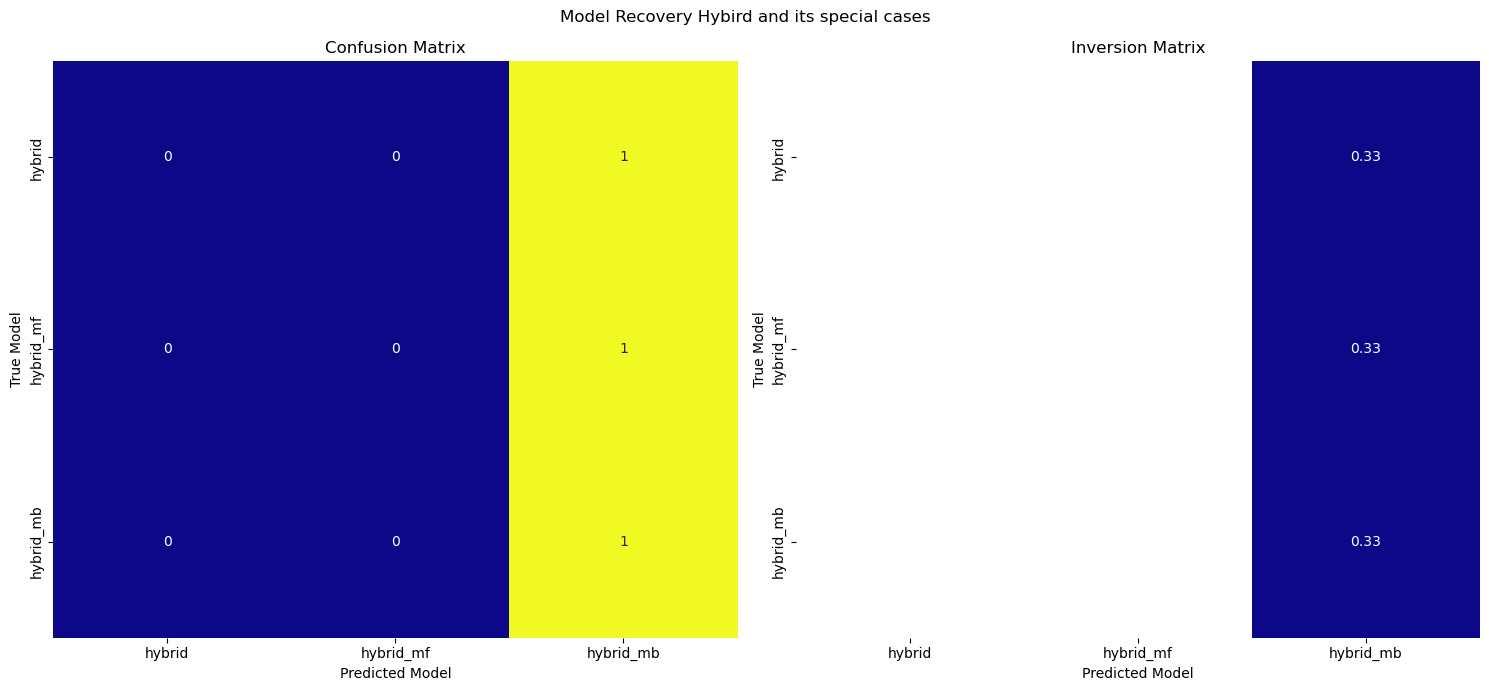

In [ ]:
plot_confusion_matrix(conf_matrix_df_hybirds, inversion_matrix_df_hybirds,
                      title=f'Model Recovery Hybird and its special cases, {NUM_RUNS} simulations.')

In [ ]:
NUM_RUNS = 20
SEED = 1

# NUM_ITERATIONS = 256  # Number of iterations for random search
NUM_INITILIZATIONS = 3 # Number of random initializations for minimize search
CONSIDER_BOTH_STAGES = True
kwargs_for_fitting_functions = {'num_initializations': NUM_INITILIZATIONS,
                                'consider_both_stages': CONSIDER_BOTH_STAGES}

models_priors_simple_vs_hybrid = {
                 'model_free': param_distributions_simple,
                 'model_based': param_distributions_simple,
                 'hybrid': param_distributions_hybrid
                }

In [ ]:
conf_matrix_df_hybirds, inversion_matrix_df_hybirds = model_recovery(models_priors_simple_vs_hybrid, num_simulations=NUM_RUNS, seed=SEED, 
                                                     fit_func_kwargs={'num_initializations': NUM_INITILIZATIONS})

## Model Comparison *(5 points)*

For this exercise you should:

*   Load and (potentially) preprocess the experimental data. (1 point)

*   Fit the two models to the data.  *(1 point)*

*   Evaluate which model performs better, taking into account fit and model complexity. *(2 points)*

*   Plot the behavior of the winning model against the data. *(1 point)**

Make sure to comment your code and provide an explanation for each code block in a preceding text block.





In [137]:
from utils import calculate_bic
from simulate import simulate
from utils import calculate_running_step_probabilities, plot_running_step_probabilities

In [138]:
# we are using the loaded data and fitted models from the previous cells
num_datapoints = len(data)

bic_mf = calculate_bic(num_params=2, num_data_points=num_datapoints, ll=best_LL_mf_minimize)
bic_mb = calculate_bic(num_params=2, num_data_points=num_datapoints, ll=best_LL_mb_minimize)
bic_hybrid = calculate_bic(num_params=7, num_data_points=num_datapoints, ll=best_LL_hybrid_minimize)
bic_hybrid_mf = calculate_bic(num_params=5, num_data_points=num_datapoints, ll=best_LL_hybrid_mf_minimize)
bic_hybrid_mb = calculate_bic(num_params=6, num_data_points=num_datapoints, ll=best_LL_hybrid_mb_minimize)

# print(f'BIC model free: {bic_mf}')
# print(f'BIC model based: {bic_mb}')
# print(f'BIC hybrid: {bic_hybrid}')
# print(f'BIC hybrid mf: {bic_hybrid_mf}')
# print(f'BIC hybrid mb: {bic_hybrid_mb}')

results_bic = pd.DataFrame({'model': ['model_free', 'model_based', 'hybrid', 'hybrid_mf', 'hybrid_mb'],
                            'bic': [bic_mf, bic_mb, bic_hybrid, bic_hybrid_mf, bic_hybrid_mb]})
display(results_bic)
model_with_lowest_bic = results_bic.loc[results_bic['bic'].idxmin(), 'model']
print(f'The model with the lowest BIC is: {model_with_lowest_bic}')

,model,bic
0,model_free,565.101746
1,model_based,560.776377
2,hybrid,591.605966
3,hybrid_mf,581.744749
4,hybrid_mb,565.391468


The model with the lowest BIC is: model_based


In [139]:
# simulate all the models with the best fitted parameters
SEED = 0
data_best_mf, _  = simulate('model_free', seed=SEED, params=best_fitted_params_mf_minimize)
data_best_mb, _ = simulate('model_based', seed=SEED, params=best_fitted_params_mb_minimize)
data_best_hybrid, _  = simulate('hybrid', seed=SEED, params=best_fitted_params_hybrid_minimize)
data_best_hybrid_mf, _  = simulate('hybrid', seed=SEED, params=best_fitted_params_hybrid_mf_minimize)
data_best_hybrid_mb, _  = simulate('hybrid', seed=SEED, params=best_fitted_params_hybrid_mb_minimize)

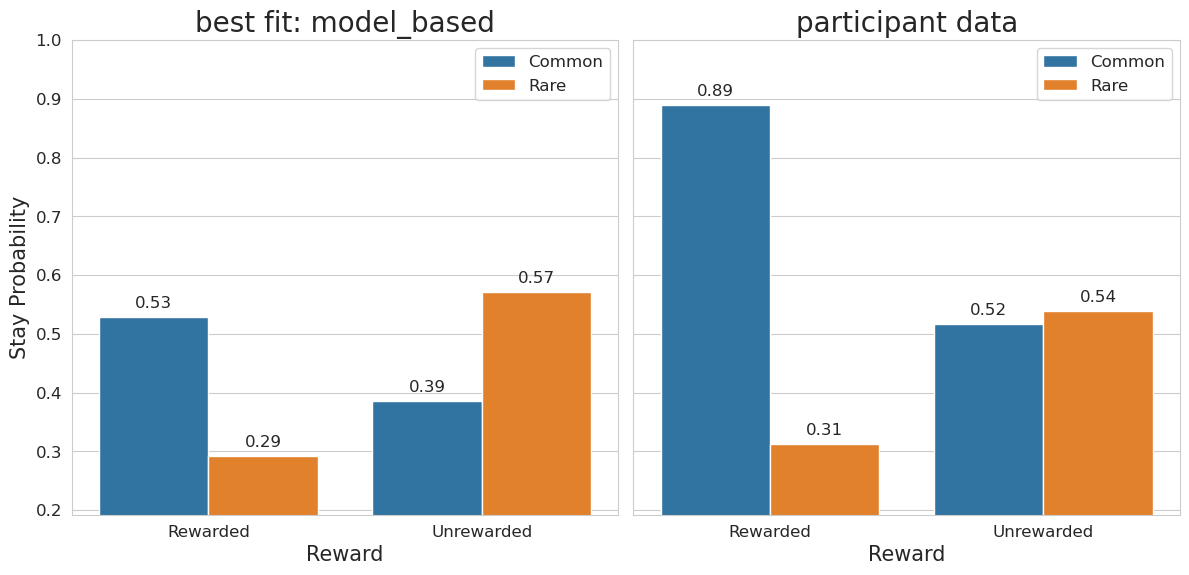

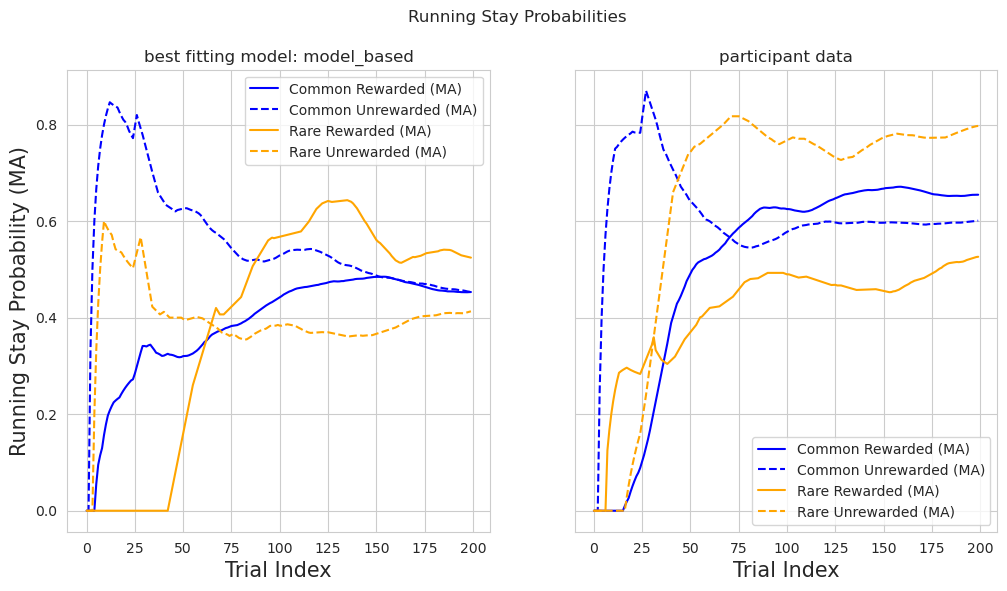

In [144]:
# plot the behavior of the best fitting model
task_dfs = {'model_free': data_best_mf, 'model_based': data_best_mb,
            'hybrid': data_best_hybrid,'hybrid_mf': data_best_hybrid_mf,
            'hybrid_mb': data_best_hybrid_mb}

# plot the stay probabilities of the best fitting model and the fitted data
stay_probability_best_model, _ = calculate_stay_probability(task_dfs[model_with_lowest_bic])
stay_probability_human_data, _ = calculate_stay_probability(data)
plot_stay_probabilities(dfs=[stay_probability_best_model, stay_probability_human_data],
                        labels=['best fit: ' + str(model_with_lowest_bic) , 'participant data'])

# plot the running stay probabilities of the best fitting model and the fitted data
AVERAGE_WINDOW = 25
behavior = calculate_running_step_probabilities(task_dfs[model_with_lowest_bic])
human_data_probs = calculate_running_step_probabilities(data)
plot_running_step_probabilities(task_dfs=[behavior, human_data_probs],
                                labels=[f'best fitting model: {model_with_lowest_bic}' , 'participant data'],
                                window_size=AVERAGE_WINDOW, title='Running Stay Probabilities',
                                max_plots_per_row=2)

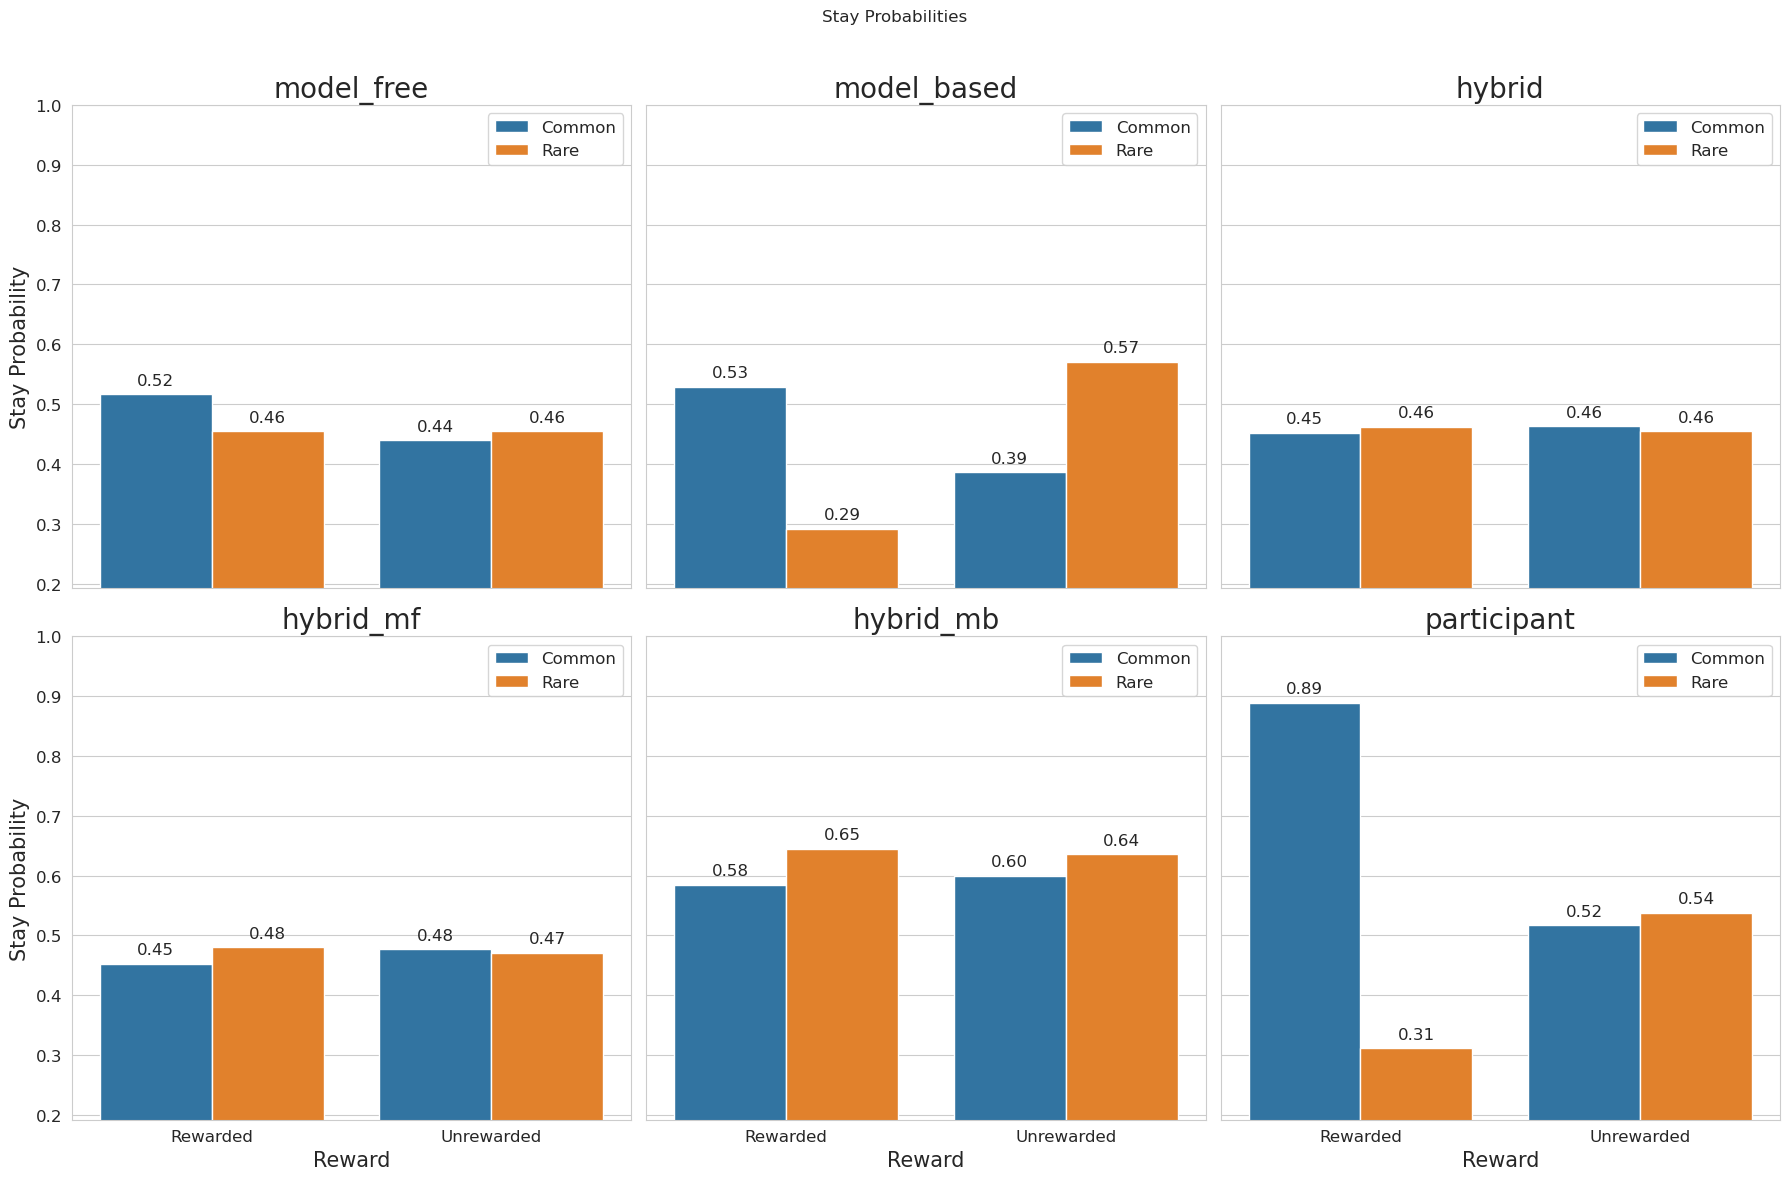

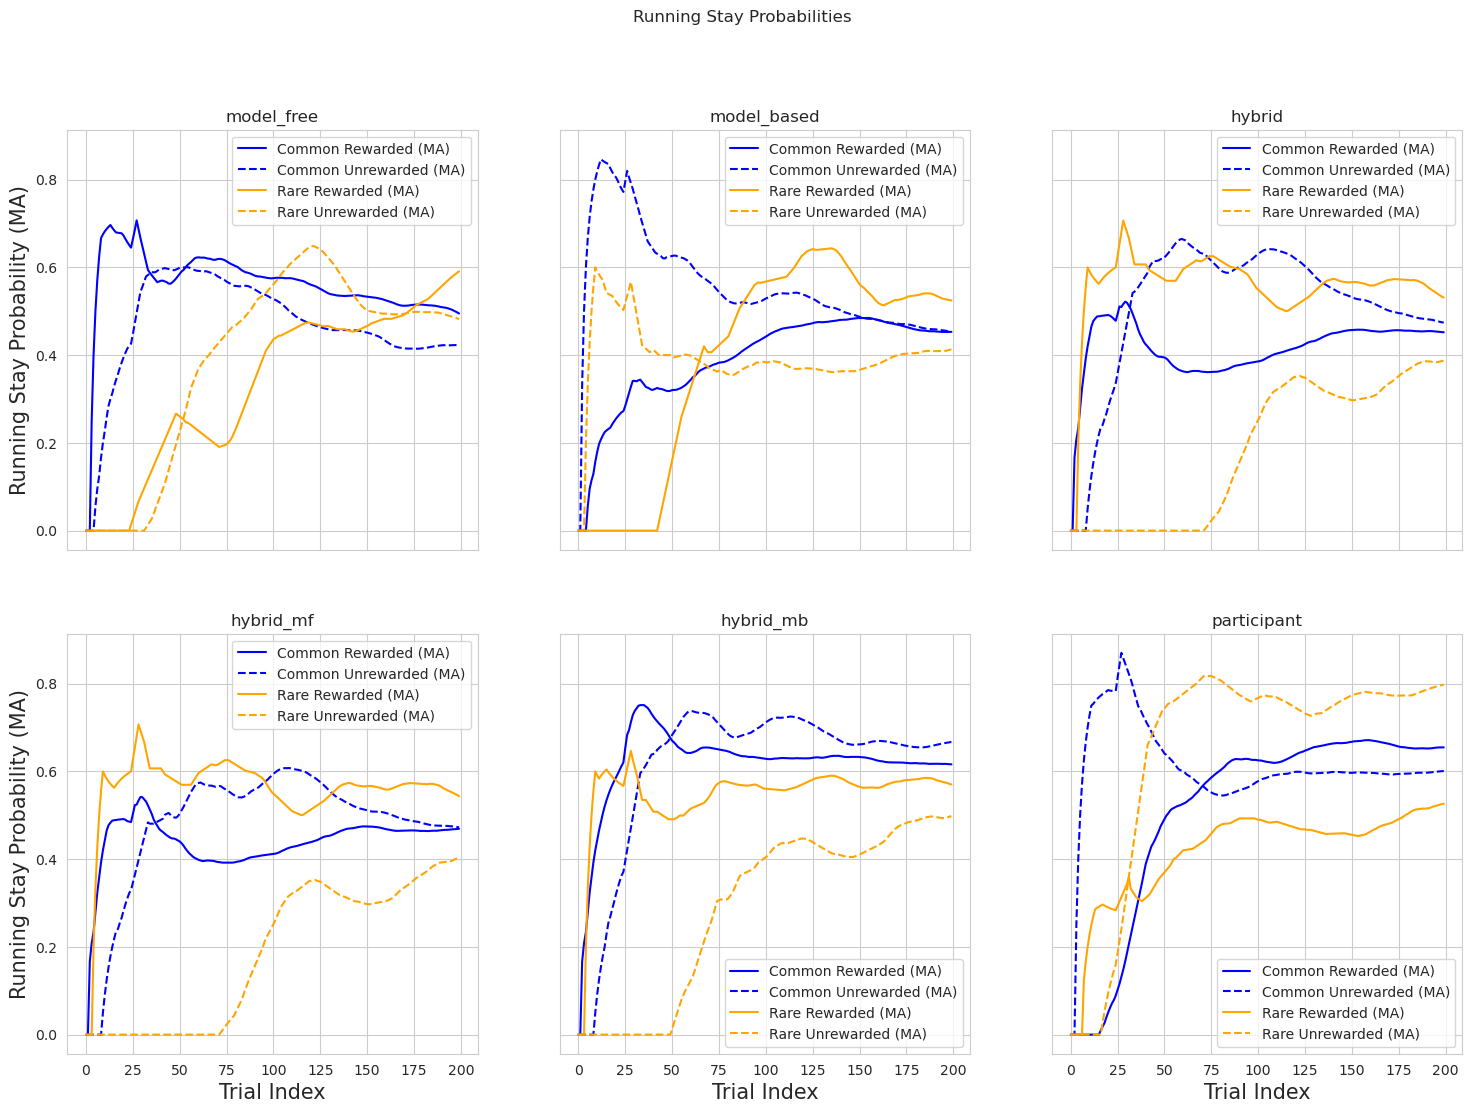

In [141]:
# plot all the models
stay_probs = {}
for model_type, model_data in task_dfs.items():
    stay_probs[model_type], _ = calculate_stay_probability(model_data)

plot_stay_probabilities(dfs=[stay_probs['model_free'], stay_probs['model_based'], stay_probs['hybrid'],
                            stay_probs['hybrid_mf'], stay_probs['hybrid_mb'], stay_probability_human_data],
                        labels=['model_free', 'model_based', 'hybrid', 'hybrid_mf', 'hybrid_mb', 'participant'],
                        title='Stay Probabilities', max_plots_per_row=3)

# plot the running stay probabilities of all the models
running_stay_probs = {}
for model_type, model_data in task_dfs.items():
    running_stay_probs[model_type] = calculate_running_step_probabilities(model_data)

plot_running_step_probabilities(task_dfs=[running_stay_probs['model_free'], running_stay_probs['model_based'],
                                            running_stay_probs['hybrid'], running_stay_probs['hybrid_mf'],
                                            running_stay_probs['hybrid_mb'], human_data_probs],
                                    labels=['model_free', 'model_based', 'hybrid', 'hybrid_mf', 'hybrid_mb', 'participant'],
                                    window_size=AVERAGE_WINDOW, title='Running Stay Probabilities',
                                    max_plots_per_row=3)


In [295]:
NUM_RUNS = 20

NUM_ITERATIONS = 256  # Number of iterations for random search
NUM_INITILIZATIONS = 5  # Number of random initializations for minimize search
CONSIDER_BOTH_STAGES = True
kwargs_for_fitting_functions = {'num_initializations': NUM_INITILIZATIONS,
                                'consider_both_stages': CONSIDER_BOTH_STAGES}
INTERPOLATION_STEPS = 21

# define the parameter space for the simple model free and based
ALPHA_RANGE = (0.01, 0.8)
BETA_RANGE = (-4, 8)
# Define parameter distributions for hybrid model and its tow special cases (model free and model based)
ALPHA_1_RANGE = (0.01, 0.8)
ALPHA_2_RANGE = (0.01, 0.8)
BETA_1_RANGE = (-4, 8)
BETA_2_RANGE = (-4, 8)
LAMBDA_RANGE = (0, 1)
W_RANGE = (0, 1)
P_RANGE = (-2, 2)

# uniform (loc, scale) => uniform (loc, loc + scale)
param_distributions_simple = {'alpha': uniform(ALPHA_RANGE[0], ALPHA_RANGE[1] - ALPHA_RANGE[0]),
                        'beta': uniform(BETA_RANGE[0], BETA_RANGE[1] - BETA_RANGE[0])}

param_distributions_hybrid = {
    'alpha_1': uniform(ALPHA_1_RANGE[0], ALPHA_1_RANGE[1] - ALPHA_1_RANGE[0]),
    'alpha_2': uniform(ALPHA_2_RANGE[0], ALPHA_2_RANGE[1] - ALPHA_2_RANGE[0]),
    'beta_1': uniform(BETA_1_RANGE[0], BETA_1_RANGE[1] - BETA_1_RANGE[0]),
    'beta_2': uniform(BETA_2_RANGE[0], BETA_2_RANGE[1] - BETA_2_RANGE[0]),
    '_lambda': uniform(LAMBDA_RANGE[0], LAMBDA_RANGE[1] - LAMBDA_RANGE[0]),
    'w': uniform(W_RANGE[0], W_RANGE[1] - W_RANGE[0]),
    'p': uniform(P_RANGE[0], P_RANGE[1] - P_RANGE[0]),
}

In [310]:
# model recovery
param_distributions_hybrid_mb = param_distributions_hybrid.copy()
param_distributions_hybrid_mb['w'] = uniform(1, 0)


models_priors = {'model_free': param_distributions_simple,
                 'model_based': param_distributions_simple,
                 'hybrid': param_distributions_hybrid}

conf_matrix_df, inversion_matrix_df = model_recovery(models_priors, num_simulations=20, seed=0, fit_func_kwargs={'num_initializations': 1})
                 

normalized coefficients:              model_free  model_based  hybrid
model_free         0.25         0.75     0.0
model_based        0.00         1.00     0.0
hybrid             0.00         0.60     0.4


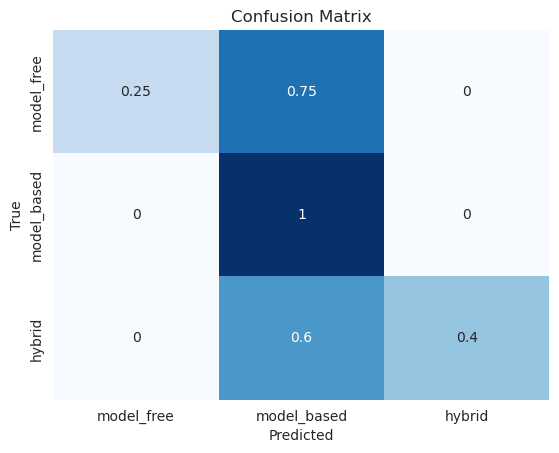

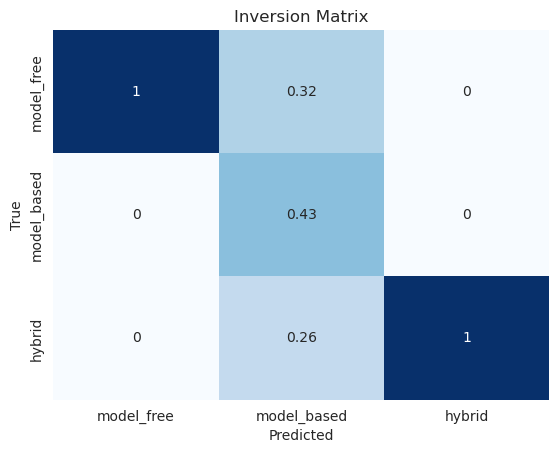

In [312]:
import seaborn as sns
import matplotlib.pyplot as plt
print('normalized coefficients:', conf_matrix_df)

sns.heatmap(conf_matrix_df, annot=True, cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# plot the inversion matrix
sns.heatmap(inversion_matrix_df, annot=True, cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Inversion Matrix')
plt.show()